<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### Preparing the dataframe for analysis:

In [2]:
# Loading the data as haus_df
haus_df = pd.read_csv('./housing.csv')

In [3]:
#Setting this option so I can see all the columns in my dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows',None)
pd.set_option('display.max_rows', 100)

In [4]:
#Opening the file and reading it.
file1 = open("data_description.txt","r")
print(file1.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Identifying fixed characteristics:

In [5]:
#Identifying unique values of MSZoning, we can see that 'C (all)' is the only non-residential variable so we can
#remove it
print(haus_df['MSZoning'].unique())

#Making the mask remove the corresponding indexes
non_res_mask = haus_df[haus_df['MSZoning'] == 'C (all)'].index

#removing the rows from the dataset
haus_df.drop(index=non_res_mask,inplace=True)
haus_df.reset_index(drop=True,inplace=True)

['RL' 'RM' 'C (all)' 'FV' 'RH']


In [6]:
#Adding all the columns that I have chosen to be fixed (not rennovatable)
fixed_char = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
              'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd','RoofStyle',
              'MasVnrType','MasVnrArea','Foundation','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
              '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
              'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea',
              'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold','YrSold',
              'SaleType','SaleCondition','SalePrice'
             ]

#Checks if all the characteristics I've typed are actually in the columns of the dataframe, will return false
#if there is anything not in there. Since it has returned true, we can proceed
all([char in haus_df.columns for char in fixed_char])

True

### Exploratory data analysis:

#### Checking for outliers:

In [7]:
#Creating a new dataframe just selecting the columns that I deemed to be fixed characteristics
fixed_df = haus_df[fixed_char].copy()

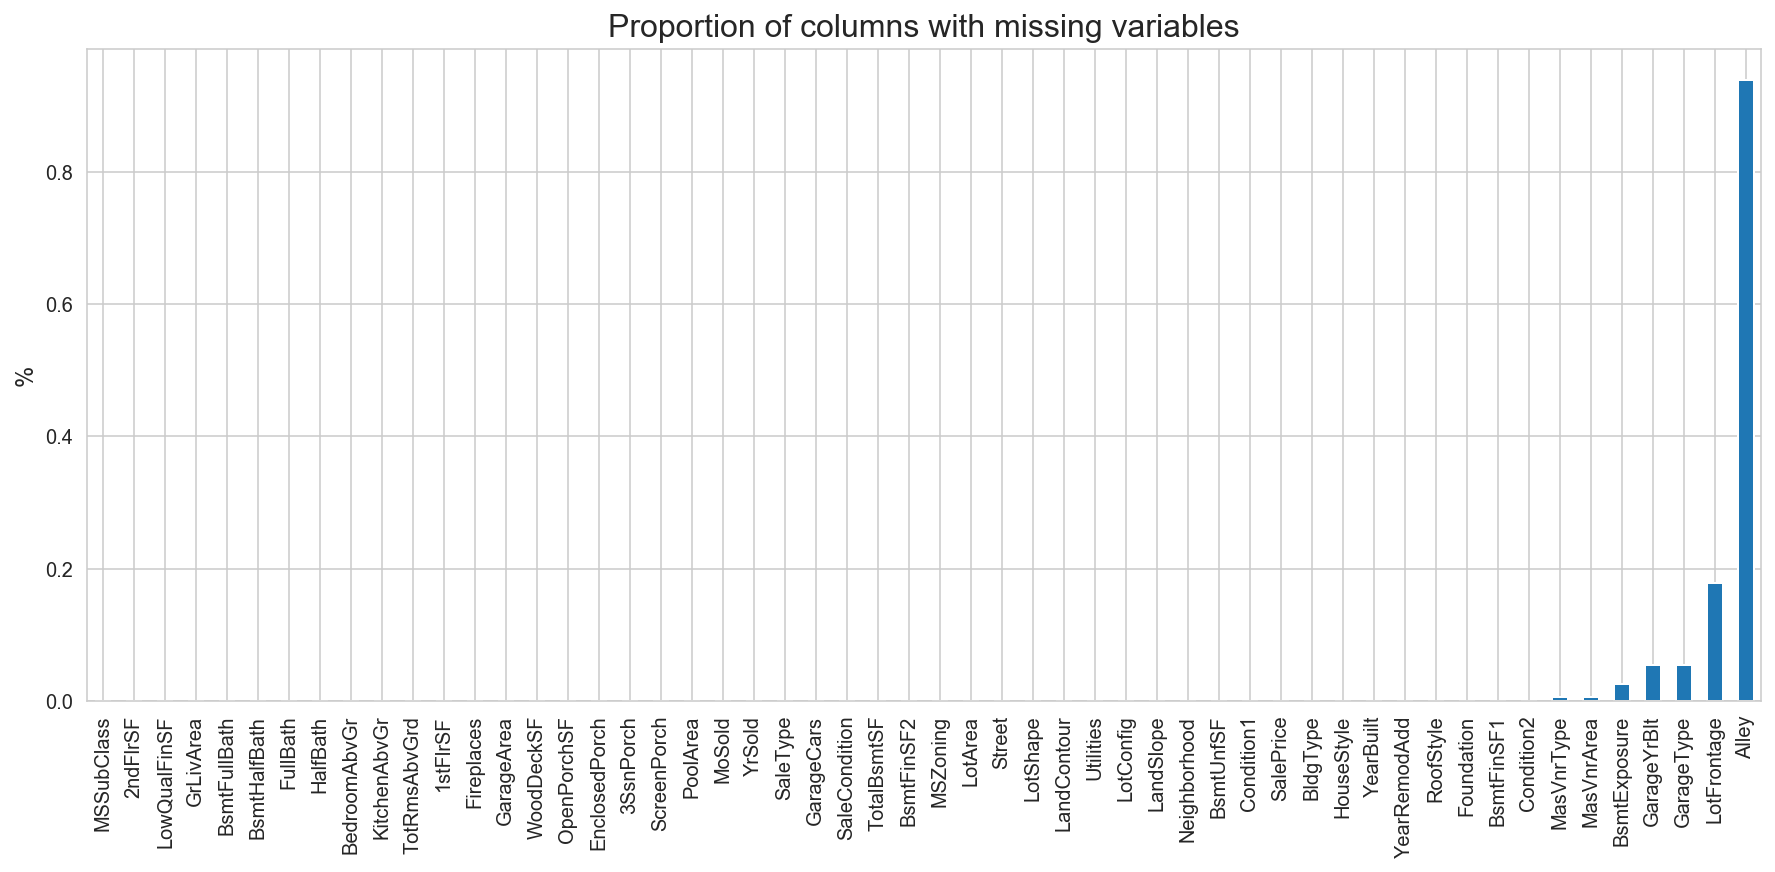

In [8]:
#Checking the proportion of each feature that has missing values
fixed_df.isnull().mean().sort_values().plot(kind='bar',figsize=(15,6))
plt.title('Proportion of columns with missing variables',fontsize=16)
plt.ylabel('%',fontsize=12)
plt.show()

* We can see that 'Alley' has 94% of values missing, so we will remove it. The second largest feature with missing variables is LotFrontage with 18% missing, but this is still enough, so we will keep. The rest are below 6% missing, so we will keep those as well.

In [9]:
#Creating a for loop that loops through all the columns and return the column name and value count with the proportion
#of its largest category greater than 90%. This will help us in selecting columns that will fudge our model with
#low variance.

def var_checker(df,thresh):
    for col in df:
        #Checks if the values in the column are 'numeric', if it is numeric it is assumed to be a continuous variable
        #and therefore excluded, we only want categorical variables
        if all(df[col].apply(lambda x:str(x).isnumeric())) == False:
            if df[col].value_counts(normalize=True).max() > thresh:
                print(col) 
                print(dict(df[col].value_counts()))
                print('-------------------')

In [10]:
var_checker(fixed_df,0.9)

Street
{'Pave': 1446, 'Grvl': 4}
-------------------
Utilities
{'AllPub': 1449, 'NoSeWa': 1}
-------------------
LandSlope
{'Gtl': 1375, 'Mod': 62, 'Sev': 13}
-------------------
Condition2
{'Norm': 1436, 'Feedr': 5, 'Artery': 2, 'RRNn': 2, 'PosN': 2, 'PosA': 1, 'RRAe': 1, 'RRAn': 1}
-------------------


* We can see Utilities has only 1 observation that isn't 'AllPub' so we will remove it.
* 'Street' also only has 6 observations that aren't 'Pave' so we will also remove it for its low variance.
* *Note: This is just a preliminary cleaning of the variables, and we will come back and may remove more depending on how are model performs.*

In [11]:
#From above, we are removing 'Alley','Utilities', and 'Street' because of their missing values or low variance.
to_drop = ['Alley','Utilities','Street']
fixed_df.drop(columns=to_drop,inplace=True)

In [12]:
#Describe will give us an idea if any of the data is out of order or incorrect
fixed_df.describe()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SalePrice
count,1450.000000,1191.000000,1450.000000,1450.000000,1450.000000,1442.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1371.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,56.903448,70.052897,10523.831724,1971.593103,1985.049655,104.404300,445.162759,46.870345,567.375862,1059.408966,1164.773103,347.394483,5.531034,1517.698621,0.427586,0.057241,1.568966,0.384828,2.870345,1.046207,6.522069,0.616552,1978.627279,1.770345,473.277931,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,6.312414,2007.812414,181654.942069
std,42.265033,24.301013,10012.185355,30.022696,20.552319,181.486539,456.353871,161.828458,442.584978,439.207322,386.646095,437.094261,46.932966,525.154207,0.519394,0.238249,0.549549,0.503450,0.814645,0.219643,1.625324,0.644991,24.592779,0.745136,212.687621,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,2.698244,1.326321,79176.485241
min,20.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1906.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,20.000000,59.000000,7544.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,796.000000,882.500000,0.000000,0.000000,1131.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.500000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,50.000000,70.000000,9496.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,475.000000,992.000000,1088.000000,0.000000,0.000000,1466.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,70.000000,80.000000,11613.500000,2001.000000,2004.000000,166.750000,713.750000,0.000000,808.000000,1301.500000,1392.000000,728.000000,0.000000,1779.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,12.000000,2010.000000,755000.000000


In [13]:
#Defining a new column that gives the age of the house when it was sold
fixed_df['HouseAge'] = fixed_df['YrSold'] - fixed_df['YearBuilt']

In [14]:
#Making a new column that gives '1' if the YearBuilt is smaller than the YearRemodAdd, this indicates whether or not
#the house has been rebuilt
is_remod_list = []
for i in range(len(fixed_df)):
    #If the year built is less than the remodd date, then it is implied that the house has been remodelled 
    if fixed_df['YearBuilt'][i] < fixed_df['YearRemodAdd'][i]:
        is_remod_list.append(1)
    else:
        is_remod_list.append(0)

#Making the new column and putting it into the dataframe
fixed_df['IsRemod'] = is_remod_list

In [15]:
garage_reblt = []
#loops through the index
for i in range(len(fixed_df)):
    #checks if the garage built year is greater than the house built year and appends '1' to the list if true
    if fixed_df['GarageYrBlt'][i] > fixed_df['YearBuilt'][i]:
        garage_reblt.append(1)
    else:
        garage_reblt.append(0)

In [16]:
#Making the new column 'GarageReblt' that indicates whether or not the garage has been rebuilt
fixed_df['GarageReBlt'] = garage_reblt

#Dropping the original columns from the dataframe
fixed_df.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt'],inplace=True)

### Converting continuous variables:

* There are many features that can be expressed as a continuous variable. The conversion will help the model.

In [17]:
continuous_feats = ['LotShape','LandContour','LandSlope','BsmtExposure']

In [18]:
#Identifying the unique categories for 'LotShape'
print(fixed_df['LotShape'].unique())

['Reg' 'IR1' 'IR2' 'IR3']


In [19]:
#Writing a function that converts the strings into integers ranking them by degree of irregularity
def lot_shape_cont(x):
    if x == 'Reg':
        return 1
    if x == 'IR1':
        return 2
    if x == 'IR2':
        return 3
    if x == 'IR3':
        return 4 
#Making the column into continuous by applying the above function
fixed_df['LotShape'] = fixed_df['LotShape'].apply(lot_shape_cont)

#Renaming the column to make it more clear that the numbers are the degree of irregularity
fixed_df.rename(columns={'LotShape':'LotShape_irregularity'},inplace=True)

In [20]:
#Identifying unique values in 'LandContour' to convert into continuous variables
fixed_df['LandContour'].unique()

array(['Lvl', 'Bnk', 'Low', 'HLS'], dtype=object)

In [21]:
#Function that converts the strings into numbers, with higher values representing higher degree of slope
def contour_cont(x):
    if x == 'Lvl':
        return 1
    if x == 'Bnk':
        return 2
    if x == 'HLS':
        return 3
    if x == 'Low':
        return 4

#Applying the function to the column
fixed_df['LandContour'] = fixed_df['LandContour'].apply(contour_cont)

#Renaming the column to reflect the continuous nature
fixed_df.rename(columns={'LandContour':'LandContour_slope_deg'},inplace=True)

In [22]:
#Identifying unique values in 'LandSlope' to convert into continuous variables
fixed_df['LandSlope'].unique()

array(['Gtl', 'Mod', 'Sev'], dtype=object)

In [23]:
def slope_cont(x):
    if x == 'Gtl':
        return 1
    if x == 'Mod':
        return 2
    if x == 'Sev':
        return 3

fixed_df['LandSlope'] = fixed_df['LandSlope'].apply(slope_cont)

fixed_df.rename(columns={'LandSlope':'Property_slope_deg'},inplace=True)

In [24]:
fixed_df['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [25]:
def bsmtexp_cont(x):
    if x == 'Gd':
        return 3
    if x == 'Av':
        return 2
    if x == 'Mn':
        return 1
    if x == 'No':
        return 1
    else:
        return 0 

fixed_df['BsmtExposure'] = fixed_df['BsmtExposure'].apply(bsmtexp_cont)

fixed_df.rename(columns={'BsmtExposure':'BsmtExposure_deg'},inplace=True)

In [26]:
#Resetting the index to make sure everything is catalogued correctly going forward
fixed_df.reset_index(drop=True,inplace=True)

### Dealing with multicollinearity:

* Now that we've cleaned our dataframe, we should also look at multicollinearity to deduce what features to remove before we convert it into our dummie variables

In [27]:
def corr_finder(df,up_bound,low_bound):
    #Taking the correlation matrix and unstacking it, then sorting it from highest/lowest absolute values
    s = df.corr().abs().unstack().sort_values(kind="quicksort",ascending=False)
    #Putting it into a dataframe
    corr_df = pd.DataFrame(s)
    #Renaming column to be clearer
    corr_df.rename(columns={0:'Correlation'},inplace=True)
    #Applying the row mask where correlation is less what we specify
    corr_id = corr_df[(corr_df['Correlation'] < up_bound) & (corr_df['Correlation'] >= low_bound)]
    return corr_id

corr_finder(fixed_df,1.0,0.8)

,,Correlation
GarageArea,GarageCars,0.883009
GarageCars,GarageArea,0.883009
GrLivArea,TotRmsAbvGrd,0.825183
TotRmsAbvGrd,GrLivArea,0.825183
TotalBsmtSF,1stFlrSF,0.819138
1stFlrSF,TotalBsmtSF,0.819138


In [28]:
#Now pulling up the highly correlated columns into a dataframe to see which ones we can remove
high_corr = corr_finder(fixed_df,1,0.8)
fixed_df[[ind[0] for ind in high_corr.index]]

,GarageArea,GarageCars,GrLivArea,TotRmsAbvGrd,TotalBsmtSF,1stFlrSF
0,548,2,1710,8,856,856
1,460,2,1262,6,1262,1262
2,608,2,1786,6,920,920
3,642,3,1717,7,756,961
4,836,3,2198,9,1145,1145
5,480,2,1362,5,796,796
6,636,2,1694,7,1686,1694
7,484,2,2090,7,1107,1107
8,468,2,1774,8,952,1022
9,205,1,1077,5,991,1077


* With GarageArea and GarageCars, the GarageCars is an inferior way to measure the space of a garage. GarageArea seems like the only logical choice since it's far more accurate and less subjective. So I will **remove GarageCars**.

In [29]:
#Dropping 'GarageCars' from the dataframe as per above
fixed_df.drop(columns=['GarageCars'],inplace=True)

* With GrLivArea and TotRmsAbvGrd are both variables that describe the amount of space 'above grade' (above the first floor). GrLivArea a much more accurate depiction of the area above, while TotRmsAbvGrd can be misleading to the amount of space above since you can have many smaller rooms or fewer big rooms. Because of this I will **remove TotRmsAbvGrd**

In [30]:
#Removing 'TotRmsAbvGrd' as per above
fixed_df.drop(columns=['TotRmsAbvGrd'],inplace=True)

* With TotalBsmtSF and 1stFlrSF, they are highly correlated because usually a basement will have the same amount of space as the ground floor. So usually the ground floor will be the same size as the basement. Removing TotalBsmtSF doesn't account for other places having a ground floor but no basement. The other basement related variables like 'BsmtFinSF1' can be proxies for size since 'TotalBsmtSF' is just the addition of the surface area of the other basement variables. So we will **remove TotalBsmtSF**

In [31]:
fixed_df.drop(columns=['TotalBsmtSF'],inplace=True)

In [32]:
#Seeing if there are any highly correlated variables left
corr_finder(fixed_df,1,0.8)

,,Correlation


### Dummifying the data:

In [33]:
#Identifying the columns that need to be converted into dummie variables
dummie_cols = ['MSSubClass','MSZoning','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
               'RoofStyle','MasVnrType','Foundation','GarageType','MoSold','YrSold','SaleType','SaleCondition']

#Checking the data types of the dummie columns, will convert any non-object columns to objects
print(fixed_df[dummie_cols].dtypes)

#Changes the column to a string for everything that isn't an object
for obj in fixed_df[dummie_cols]:
    if fixed_df[obj].dtype != 'object':
        fixed_df[obj] = fixed_df[obj].apply(str)

MSSubClass        int64
MSZoning         object
LotConfig        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
MasVnrType       object
Foundation       object
GarageType       object
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
dtype: object


In [34]:
#Assigning a new temp dataframe that is the dummies of all the above mentioned categorical columns
temp_df = pd.get_dummies(fixed_df[dummie_cols])

#Concatenating it onto the original dataframe
dummie_fixed_df = pd.concat([temp_df,fixed_df],axis=1)

#Dropping the columns that were converted into dummies, so we only have numerical and dummies variables in our model
dummie_fixed_df.drop(columns=dummie_cols,inplace=True)

In [35]:
#Checking if there are any missing values in the data we have so far by summing the null values and seeing how many
#are missing. Can see there are 3 categories with missing values
dummie_fixed_df.isnull().sum().sort_values(ascending=False)

LotFrontage             259
MasVnrArea                8
GarageReBlt               0
Condition1_RRNn           0
Condition1_RRNe           0
Condition1_RRAn           0
Condition1_RRAe           0
Condition1_PosN           0
Condition1_PosA           0
Condition1_Norm           0
Condition1_Feedr          0
Neighborhood_NridgHt      0
Condition1_Artery         0
Neighborhood_Veenker      0
Neighborhood_Timber       0
Neighborhood_StoneBr      0
Neighborhood_Somerst      0
Neighborhood_SawyerW      0
Neighborhood_Sawyer       0
Neighborhood_SWISU        0
Condition2_Artery         0
Condition2_Feedr          0
Condition2_Norm           0
Condition2_PosA           0
HouseStyle_SLvl           0
HouseStyle_SFoyer         0
HouseStyle_2Story         0
HouseStyle_2.5Unf         0
HouseStyle_2.5Fin         0
HouseStyle_1Story         0
HouseStyle_1.5Unf         0
HouseStyle_1.5Fin         0
BldgType_TwnhsE           0
BldgType_Twnhs            0
BldgType_Duplex           0
BldgType_2fmCon     

In [36]:
#MasVnrArea is a continuous variable, so we're assuming that the 'nan' values are 0
dummie_fixed_df['MasVnrArea'] = dummie_fixed_df['MasVnrArea'].fillna(0)

#LotFrontage is also a continuous variable, and perhaps the 'nan' means there is no street connected to the property
#so we will also assume it is 0
dummie_fixed_df['LotFrontage'] = dummie_fixed_df['LotFrontage'].fillna(0)

In [37]:
#Checking for any null values we might have missed
dummie_fixed_df.isnull().sum().sort_values(ascending=False)

GarageReBlt             0
Condition2_Norm         0
Condition2_Artery       0
Condition1_RRNn         0
Condition1_RRNe         0
Condition1_RRAn         0
Condition1_RRAe         0
Condition1_PosN         0
Condition1_PosA         0
Condition1_Norm         0
Condition1_Feedr        0
Condition1_Artery       0
Neighborhood_Veenker    0
Neighborhood_Timber     0
Neighborhood_StoneBr    0
Neighborhood_Somerst    0
Neighborhood_SawyerW    0
Neighborhood_Sawyer     0
Neighborhood_SWISU      0
Condition2_Feedr        0
Condition2_PosA         0
RoofStyle_Gambrel       0
Condition2_PosN         0
RoofStyle_Flat          0
HouseStyle_SLvl         0
HouseStyle_SFoyer       0
HouseStyle_2Story       0
HouseStyle_2.5Unf       0
HouseStyle_2.5Fin       0
HouseStyle_1Story       0
HouseStyle_1.5Unf       0
HouseStyle_1.5Fin       0
BldgType_TwnhsE         0
BldgType_Twnhs          0
BldgType_Duplex         0
BldgType_2fmCon         0
BldgType_1Fam           0
Condition2_RRNn         0
Condition2_R

In [38]:
#Resetting the index for cleanliness
dummie_fixed_df.reset_index(drop=True,inplace=True)

* Before proceeding, I will do a final check for multicollinear dummie variables.

In [39]:
corr_finder(dummie_fixed_df,1,0.8)

,,Correlation
SaleCondition_Partial,SaleType_New,0.986811
SaleType_New,SaleCondition_Partial,0.986811
MSSubClass_190,BldgType_2fmCon,0.982846
BldgType_2fmCon,MSSubClass_190,0.982846
HouseStyle_SLvl,MSSubClass_80,0.942242
MSSubClass_80,HouseStyle_SLvl,0.942242
HouseStyle_1.5Fin,MSSubClass_50,0.939395
MSSubClass_50,HouseStyle_1.5Fin,0.939395
RoofStyle_Hip,RoofStyle_Gable,0.934761
RoofStyle_Gable,RoofStyle_Hip,0.934761


* You'll notice that there are quite a few very highly correlated variables. I have deduced that it is because they are essentially saying the same thing, just under a different umbrella category. Below I will remove the ones that I believe are redundant.

In [40]:
#Columns that I'll drop
dummie_cols_to_drop = ['SaleCondition_Partial','MSSubClass_190','MSSubClass_80','MSSubClass_50','RoofStyle_Gable',
                       'MSSubClass_45']

In [41]:
#Finally dropping them before I proceed further
dummie_fixed_df.drop(columns=dummie_cols_to_drop,inplace=True)

### Building the model (round 1):

In [42]:
#importing relevant modules to fit and assess my model
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
#importing the mean_squared_error method to evaluate how our model is going
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as sm2
import statsmodels.discrete.discrete_model as sm3

In [43]:
#Splitting the variables for testing/training by whether they were before 2010 or after, applying the row mask
#for all rows that aren't YrSold = 2010, then extracting the features and targets
X_train = dummie_fixed_df[dummie_fixed_df['YrSold_2010'] == 0][[col for col in dummie_fixed_df if col != 'SalePrice']]
y_train = dummie_fixed_df[dummie_fixed_df['YrSold_2010'] == 0]['SalePrice'].values

#Applying the row mask for all rows that are YrSold = 2010, then extracting the features and targets
X_test = dummie_fixed_df[dummie_fixed_df['YrSold_2010'] == 1][[col for col in dummie_fixed_df if col != 'SalePrice']]
y_test = dummie_fixed_df[dummie_fixed_df['YrSold_2010'] == 1]['SalePrice'].values

#Standardising the X training values for the model via the sklearn.preprocessing module
scale = StandardScaler()
Xstd_train = scale.fit_transform(X_train)
Xstd_train = sm.add_constant(Xstd_train)

#Standardising the X testing values for the model via the sklearn.preprocessing module
Xstd_test = scale.transform(X_test)
Xstd_test = sm.add_constant(Xstd_test, has_constant='add')

In [44]:
#Fitting the model to the standardised X variables
model_orig = sm.OLS(y_train,Xstd_train).fit()

#Printing out the model summary
model_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     47.15
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:26:16   Log-Likelihood:                -14988.
No. Observations:                1278   AIC:                         3.026e+04
Df Residuals:                    1134   BIC:                         3.101e+04
Df Model:                         143                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.82e+05    890.889    204.279      0.000     1.8e+05    1.84e+05
x1         -6073.6301   5340.949     -1.137      0.256   -1.66e+04    4405.622
x2         -9735.9538   4943.552     -1.969      0.049   -1.94e+04     -36.417
x3         -2044.6062   2236.274     -0.914      0.361   -6432.305    2343.092
x4          2000.4314   4896.650      0.409      0.683   -7607.080    1.16e+04
x5          -578.0232   2364.043     -0.245      0.807   -5216.413    4060.366
x6          -200.2679   1097.658     -0.182      0.855   -2353.937    1953.401
x7         -6692.3403   4638.151     -1.443      0.149   -1.58e+04    2407.982
x8           547.7237   2264.594      0.242      0.809   -3895.541    4990.989
x9         -1182.3679   2323.240     -0.509      0.611   -5740.700    3375.965
x10          179.1174   1802.046      0.099      0.921   -3356.602    3714.837
x11          204.1312   1227.591      0.166      0.868   -2204.474    2612.736
x12            1.0228   1751.534      0.001      1.000   -3435.588    3437.634
x13           66.3666   1013.567      0.065      0.948   -1922.311    2055.044
x14         -203.8328    960.871     -0.212      0.832   -2089.117    1681.452
x15          209.6568   1257.867      0.167      0.868   -2258.352    2677.665
x16         -110.4621    685.540     -0.161      0.872   -1455.531    1234.607
x17         2201.4093    920.484      2.392      0.017     395.366    4007.452
x18        -1498.6829    905.199     -1.656      0.098   -3274.737     277.371
x19        -1314.3408    975.401     -1.347      0.178   -3228.134     599.452
x20         -352.2254    556.803     -0.633      0.527   -1444.705     740.254
x21          548.5638   1136.349      0.483      0.629   -1681.019    2778.146
x22          713.5585    966.011      0.739      0.460   -1181.811    2608.928
x23         2727.1766   1258.352      2.167      0.030     258.217    5196.136
x24         -750.8575   1298.323     -0.578      0.563   -3298.244    1796.529
x25        -2061.4954   1101.673     -1.871      0.062   -4223.043     100.052
x26        -1686.0889   1107.299     -1.523      0.128   -3858.674     486.496
x27         2817.6993   1103.775      2.553      0.011     652.029    4983.369
x28        -6325.4098   1001.935     -6.313      0.000   -8291.264   -4359.556
x29        -2730.1889   1178.484     -2.317      0.021   -5042.444    -417.934
x30        -1842.8978   1264.330     -1.458      0.145   -4323.586     637.791
x31          121.4157   1273.538      0.095      0.924   -2377.340    2620.172
x32        -3137.4568    952.493     -3.294      0.001   -5006.304   -1268.610
x33        -3619.9066   1090.504     -3.319      0.001   -5759.538   -1480.275
x34         2301.6730   1005.031      2.290      0.022     329.744    4273.602
x35        -2927.2783   1058.703     -2.765      0.006   -5004.515    -850.042
x3

### Evaluation (round 1):

In [45]:
#Writing a function that returns the baseline mean squared error for our model to compare to the actual values
def baseline(y_actual):
    #The mean of the actual test data
    meanprice = y_actual.mean()
    #Generating an array of means from which we can minus from the observed data
    nullprediction = [meanprice for i in range(len(y_actual))]
    #Finally returning the mse for from the means
    return np.sqrt(mean_squared_error(y_actual,  nullprediction))

In [46]:
#Function that returns the baseline mean absolute error for our model to cmopare to the actual values
def baseline_abs(y_actual):
    meanprice=y_actual.mean()
    nullpred = [meanprice for i in range(len(y_actual))]
    return mean_absolute_error(y_actual,nullpred)

In [47]:
Xstd_test.shape

(172, 159)

In [48]:
#Assigning the model's predicted values to 'y_pred'
y_pred = model_orig.predict(Xstd_test)

In [49]:
#Now we're using our predicted values generated from our model and using mean squared error to evaluate 
y_actual = y_test
print('Baseline RMSE :',baseline(y_test))
print('Original RMSE :',np.sqrt(mean_squared_error(y_actual, y_pred)))

Baseline RMSE : 79733.29983261495
Original RMSE : 30260.29161023033


In [50]:
print('Baseline ABS Err:',baseline_abs(y_actual))
print('Original ABS Err:',mean_absolute_error(y_actual,y_pred))

Baseline ABS Err: 57219.104651162794
Original ABS Err: 21531.33335103424


In [51]:
#Writing a function that calculates the R^2 of the data based on the test/train set
def R2_manual(y_pred,y_actual):
    ss_tot = sum(np.square(y_actual - y_actual.mean()))
    ss_res = sum(np.square(y_actual - y_pred))
    R2 = 1 - (ss_res / ss_tot)
    return R2

In [52]:
print('R^2 :',R2_manual(y_pred,y_actual))

R^2 : 0.8559654296330657


In [53]:
#Writing a function that plots the predicted values against the actual values
def reg_plotter(y_pred,y_actual,size=(5,3),labels=12,titlesize=18,title=''):
    fig = plt.figure(figsize=size)
    sns.regplot(x=y_pred,y=y_actual,color='r')
    plt.xlabel('Predicted values',fontsize=labels)
    plt.ylabel('Actual values',fontsize=labels)
    plt.title((title + ' regression plot'),fontsize=titlesize)
    plt.show()

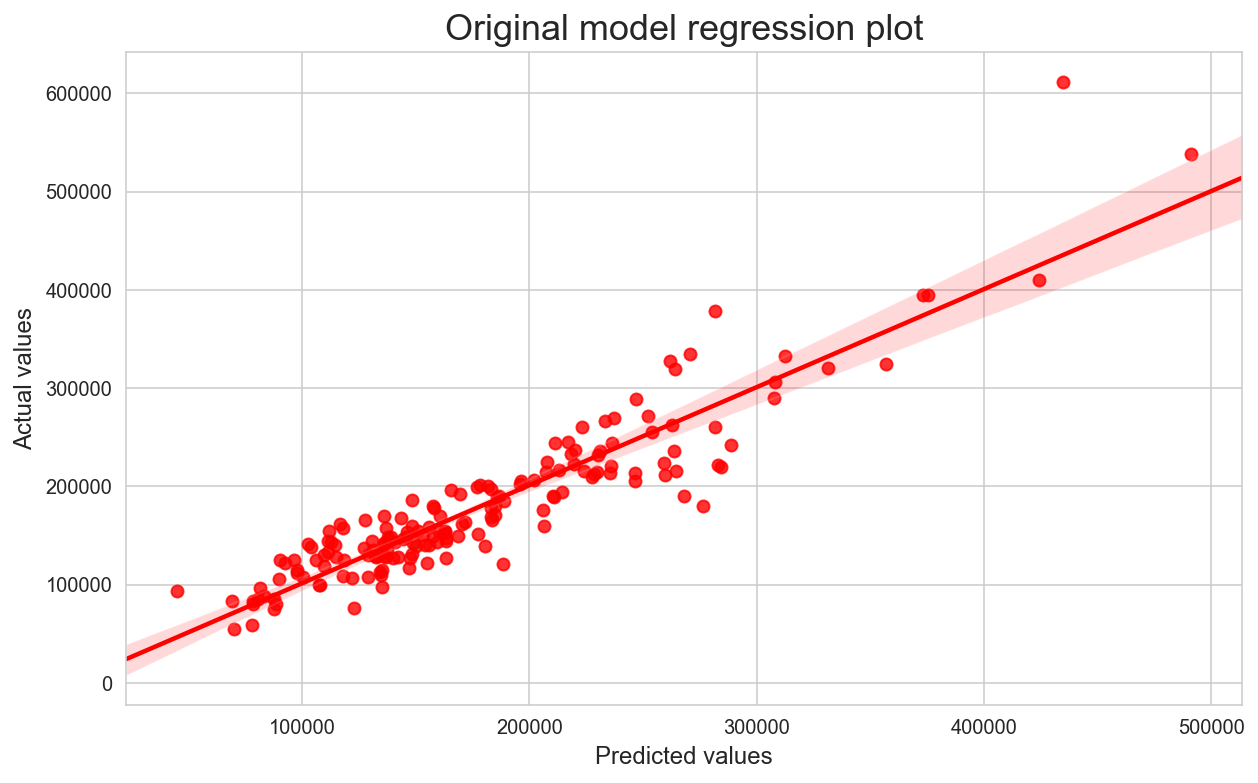

In [54]:
reg_plotter(y_pred,y_actual,size=(10,6),title='Original model')

* The regression reveals that our model has a relatively low variance. It also shows us the existence of a very high outlier. 

In [55]:
#Writing a function that plots the residuals against
def resid_plotter(y_pred,y_actual,size=(5,3),labels=12,titlesize=18,title=''):
    fig = plt.figure(figsize=size)
    sns.residplot(x=y_pred,y=y_actual)
    plt.ylabel('Residuals',fontsize=labels)
    plt.xlabel('Predicted values',fontsize=labels)
    plt.title((title + ' residual plot'),fontsize=titlesize)
    plt.show()

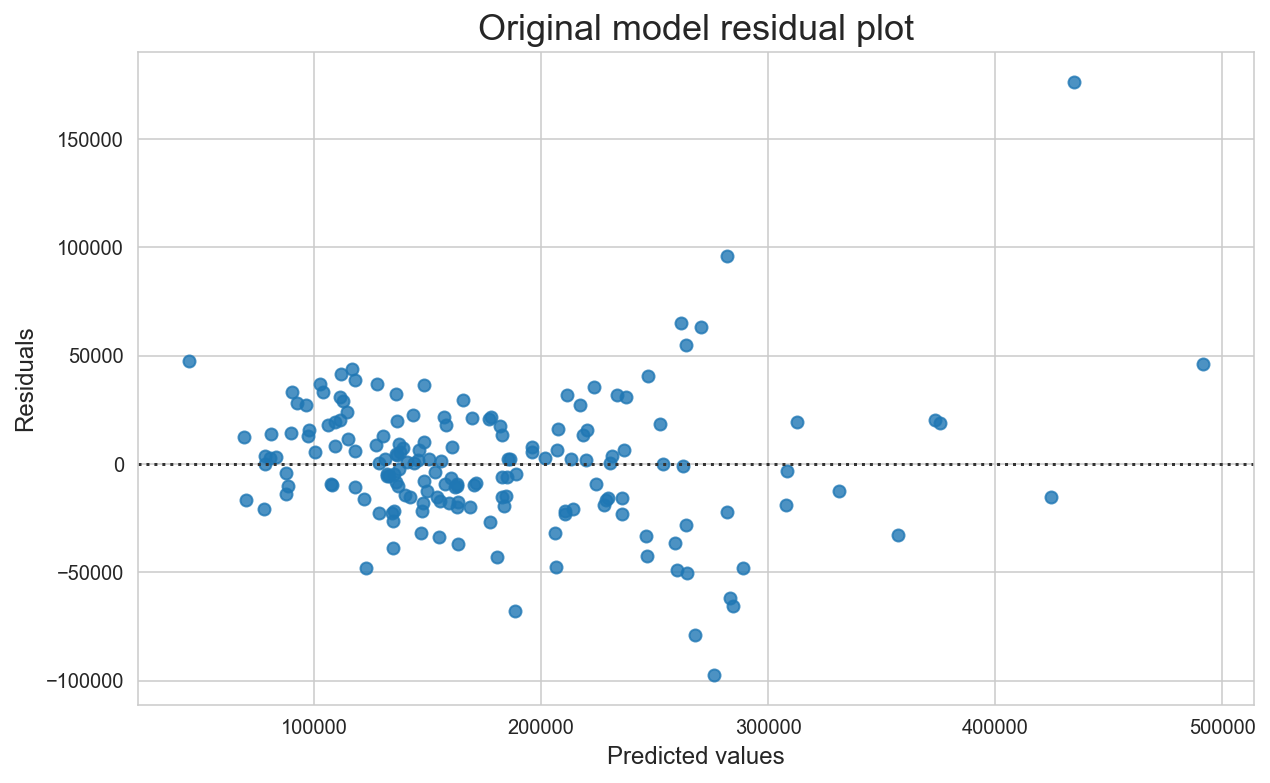

In [56]:
resid_plotter(y_pred,y_actual,size=(10,6),title='Original model')

### Building the model (round 2):

#### Feature Selection:

* In the below sections I will be using three different methods to assess what features to keep or discard. They are:
    * Find significance via OLS model summary feature (gives t-stat and p-value for every coefficient) and removing any coefficient with a p-value greater than our threshold value of 0.05
    * Taking the top 50 highest p-value coefficients
    * ElasticNet: Finding which coefficients get regularised to 0
    
#### Finding significance of coefficients:
   

In [57]:
#This function takes the summary table and turns it into a standalone dataframe which we can manipulate
def summary_helper(y,X):
    scale = StandardScaler()
    Xn = sm.add_constant(X)
    Xstd = scale.fit_transform(X)
    Xstd = sm.add_constant(Xstd)
    
    #Because standardising the coefficients removes their name, I am printing the summary non-standardised model's 
    #index names and then putting them into the standardised summary (as below)
    mod_norm = sm.OLS(y,Xn).fit()
    html_norm = mod_norm.summary().tables[1].as_html()
    norm_df = pd.read_html(html_norm, header=0, index_col=0)[0]
    
    mod_stand = sm.OLS(y,Xstd).fit()
    html_stand = mod_stand.summary().tables[1].as_html()
    stand_df = pd.read_html(html_stand, header=0, index_col=0)[0]
    stand_df.index = norm_df.index
    
    #stand_df is the final product with a workable summary dataframe with the named coefficients
    #this will help identifying which coeffs to remove
    return stand_df

In [58]:
#Assigning the workable summary dataframe to a new variable
enhanced_summary = summary_helper(y_train,X_train)
enhanced_summary

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,coef,std err,t,P>|t|,[0.025,0.975]
const,1.820000e+05,8.908890e+02,204.279,0.000,1.800000e+05,1.840000e+05
MSSubClass_120,-6.073630e+03,5.340949e+03,-1.137,0.256,-1.660000e+04,4.405622e+03
MSSubClass_160,-9.735954e+03,4.943552e+03,-1.969,0.049,-1.940000e+04,-3.641700e+01
MSSubClass_180,-2.044606e+03,2.236274e+03,-0.914,0.361,-6.432305e+03,2.343092e+03
MSSubClass_20,2.000431e+03,4.896650e+03,0.409,0.683,-7.607080e+03,1.160000e+04
MSSubClass_30,-5.780232e+02,2.364043e+03,-0.245,0.807,-5.216413e+03,4.060366e+03
MSSubClass_40,-2.002679e+02,1.097658e+03,-0.182,0.855,-2.353937e+03,1.953401e+03
MSSubClass_60,-6.692340e+03,4.638151e+03,-1.443,0.149,-1.580000e+04,2.407982e+03
MSSubClass_70,5.477237e+02,2.264594e+03,0.242,0.809,-3.895541e+03,4.990989e+03
MSSubClass_75,-1.182368e+03,2.323240e+03,-0.509,0.611,-5.740700e+03,3.375965e+03


In [59]:
#Defining the top 50 least significant coefficients (for later use)
least_sig50 = list(enhanced_summary.sort_values(by='P>|t|',ascending=False).head(50).index)

In [60]:
#Applying a mask that gives us only coefficients with a p-value greater than 0.05 (significance threshold)
sig_coef = enhanced_summary[enhanced_summary['P>|t|'] > 0.05].sort_values(by='P>|t|',ascending=False)

#Assigning a new variable to the names of the high p-value coefficients we will compare this later
sig_names = list(sig_coef.index)

#### Elastic Net:

In [61]:
#Generates an array of ratios between 0.01 and 1 to find the optimal ratio it will iterate through 0.01,0.02..0.99 etc.
l1_ratios = np.linspace(0.01, 1.0, 100)

#Using the ElasticNetCV to find the optimal l1 ratio and alpha, cross validating over 10 folds, verbose=1 to reduce
#computational processing time
opt_en = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, verbose=1,n_jobs=-1)
opt_en.fit(Xstd_train,y_train)

#Printing out what the optimal alpha and ratio was
print('Optimal alpha is',opt_en.alpha_)
print('Optimal ratio is',opt_en.l1_ratio_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal alpha is 56.559702444962774
Optimal ratio is 0.99


...................................................................................................[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   50.6s finished


In [62]:
#Using fit regularize with the optimal alpha and ratio
#Creating two models so I can use the 'norm' feature names for the 'stand' paramaters
mod_norm = sm.OLS(y_train,sm.add_constant(X_train)).fit_regularized(method='elastic_net',
                                                                 alpha=opt_en.alpha_,L1_wt=opt_en.l1_ratio_)

#This is the model I'll actually be using
mod_stand = sm.OLS(y_train,Xstd_train).fit_regularized(method='elastic_net',
                                                       alpha=opt_en.alpha_,L1_wt=opt_en.l1_ratio_)

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [63]:
#Two new dataframes made from the above model parameters
mod_norm_df = pd.DataFrame(mod_norm.params)
mod_stand_df = pd.DataFrame(mod_stand.params)

#Naming the standard coefficients for reference for later
mod_stand_df.index = mod_norm_df.index

#Renaming for clarity
mod_stand_df.rename(columns={0:'coef_value'},inplace=True)
mod_stand_df

,coef_value
const,116207.290590
MSSubClass_120,-133.273254
MSSubClass_160,-1971.759327
MSSubClass_180,-54.283526
MSSubClass_20,1462.924299
MSSubClass_30,-1555.222830
MSSubClass_40,119.475817
MSSubClass_60,1406.320261
MSSubClass_70,799.545419
MSSubClass_75,441.864680


In [64]:
#Assigning variable for the coefficient names that had been regularised to 0
en_names = list(mod_stand_df[mod_stand_df['coef_value'] == 0].index)

### Evaluation (round 2):

* For this evaluation I will compare my model three times: First making a new dataframe removing the insignificant coefficients, second removing the elastic net regularised to 0 coefficients, and finally using the coefficients that both significance and elastic net removed.


* After finding the coefficients with high p-values (not significant predictors) and regularising the values via elastic net penalty. I have found the features that have both been regularised to 0 and have high p-values. I have stored these feature names in **common_bad_feats**. 


* Out of the all the features in the **common_bad_feats** list, there four that were continuous (non-categorical). They  were:
    * **LandContour_slope_deg**
    * **EnclosedPorch**
    * **Property_slope_deg**
   

In [65]:
#The coefficients above 0.05 p-value, note: keeping 'YrSold' to distinguish between train/test data
sig_names

#The top 50 least insignificant values note: also keeping 'YrSold' as per above
least_sig50

#The regularised to 0 coefficients
en_names.remove('YrSold_2010')

#Assigning a variable that finds the common names from the high p-value coefs and regularised to 0 coefs
common_bad_feats = list(set(sig_names) & set(en_names) & set(least_sig50))

#assigning a variable that only removes the four continuous variables as mentioned above
cont_feats = ['LandContour_slope_deg','EnclosedPorch','Property_slope_deg']

In [69]:
#Creating a dataframe with the non-significant features dropped
sig_fixed_df = dummie_fixed_df.drop(columns=sig_names)
#Creating a dataframe with the 50 least significant features dropped
least_sig50_df = dummie_fixed_df.drop(columns=least_sig50)
#Creating a dataframe with the elastic net regularised to 0 features dropped
en_fixed_df = dummie_fixed_df.drop(columns=en_names)
#Creating a dataframe with the common non-sig / elastic netted features dropped
all_fixed_df = dummie_fixed_df.drop(columns=common_bad_feats)
#Creating a dataframe with the continuous features identified above dropped
cont_fixed_df = dummie_fixed_df.drop(columns=cont_feats)

#Assigning the training X's depending on sig/en/all
Xsig_train = sig_fixed_df[sig_fixed_df['YrSold_2010'] == 0][[col for col in sig_fixed_df if col != 'SalePrice']]
Xleast_train = least_sig50_df[least_sig50_df['YrSold_2010'] == 0][[col for col in least_sig50_df if col != 'SalePrice']]
Xen_train = en_fixed_df[en_fixed_df['YrSold_2010'] == 0][[col for col in en_fixed_df if col != 'SalePrice']]
Xall_train = all_fixed_df[all_fixed_df['YrSold_2010'] == 0][[col for col in all_fixed_df if col != 'SalePrice']]
Xcont_train = cont_fixed_df[cont_fixed_df['YrSold_2010'] == 0][[col for col in cont_fixed_df if col != 'SalePrice']]
#the y train remains the same as I'm only removing columns, the target stays the same
y_train = dummie_fixed_df[dummie_fixed_df['YrSold_2010'] == 0]['SalePrice'].values

#Assigning the test X's depending on sig/en/all
Xsig_test = sig_fixed_df[sig_fixed_df['YrSold_2010'] == 1][[col for col in sig_fixed_df if col != 'SalePrice']]
Xleast_test = least_sig50_df[least_sig50_df['YrSold_2010'] == 1][[col for col in least_sig50_df if col != 'SalePrice']]
Xen_test = en_fixed_df[en_fixed_df['YrSold_2010'] == 1][[col for col in en_fixed_df if col != 'SalePrice']]
Xall_test = all_fixed_df[all_fixed_df['YrSold_2010'] == 1][[col for col in all_fixed_df if col != 'SalePrice']]
Xcont_test = cont_fixed_df[cont_fixed_df['YrSold_2010'] == 1][[col for col in cont_fixed_df if col != 'SalePrice']]
#the y test remains the same as I'm only removing columns, target does not change
y_test = dummie_fixed_df[dummie_fixed_df['YrSold_2010'] == 1]['SalePrice'].values

#Standardising the X training/testing values for the model via the sklearn.preprocessing module
scale = StandardScaler()
Xsigstd_train = scale.fit_transform(Xsig_train)
Xsigstd_train = sm.add_constant(Xsigstd_train, has_constant='add')

Xsigstd_test = scale.transform(Xsig_test)
Xsigstd_test = sm.add_constant(Xsigstd_test, has_constant='add')

Xleaststd_train = scale.fit_transform(Xleast_train)
Xleaststd_train = sm.add_constant(Xleaststd_train, has_constant='add')

Xleaststd_test = scale.transform(Xleast_test)
Xleaststd_test = sm.add_constant(Xleaststd_test, has_constant='add')

Xenstd_train = scale.fit_transform(Xen_train)
Xenstd_train = sm.add_constant(Xenstd_train, has_constant='add')

Xenstd_test = scale.transform(Xen_test)
Xenstd_test = sm.add_constant(Xenstd_test, has_constant='add')

Xallstd_train = scale.fit_transform(Xall_train)
Xallstd_train = sm.add_constant(Xallstd_train, has_constant='add')

Xallstd_test = scale.transform(Xall_test)
Xallstd_test = sm.add_constant(Xallstd_test, has_constant='add')

Xcontstd_train = scale.fit_transform(Xcont_train)
Xcontstd_train = sm.add_constant(Xcontstd_train, has_constant='add')

Xcontstd_test = scale.transform(Xcont_test)
Xcontstd_test = sm.add_constant(Xcontstd_test, has_constant='add')

#Yes this is a huge cell and not easy on the eyes, sorry in advance!

In [70]:
#Fitting the model to the standardised X variables
model_sig = sm.OLS(y_train,Xsigstd_train).fit()
model_least = sm.OLS(y_train,Xleaststd_train).fit()
model_en = sm.OLS(y_train,Xenstd_train).fit()
model_all = sm.OLS(y_train,Xallstd_train).fit()
model_cont = sm.OLS(y_train,Xcontstd_train).fit()

#Making a list of the models for iterating
models = [model_sig,model_least,model_en,model_all,model_cont]

In [71]:
#Assigning the model's predicted values to 'y_pred'
ysig_pred = ['Over threshold',model_sig.predict(Xsigstd_test)]
yleast_pred = ['Least significant',model_least.predict(Xleaststd_test)]
yen_pred = ['Elastic Net',model_en.predict(Xenstd_test)]
yall_pred = ['Common features',model_all.predict(Xallstd_test)]
ycont_pred = ['Continuous features',model_cont.predict(Xcontstd_test)]

#Making a list of the predictions for iterataing
predictions = [ysig_pred,yleast_pred,yen_pred,yall_pred,ycont_pred]

In [72]:
#Now we're using our predicted values generated from our model and using mean squared error to evaluate 
y_actual = y_test

print('RMSE:')
print('----------')
for pred in predictions:
    print(pred[0],':',np.sqrt(mean_squared_error(y_actual, pred[1])))
    
print('----------')
print('Baseline :',baseline(y_test))
print('Original :',np.sqrt(mean_squared_error(y_actual, y_pred)))

RMSE:
----------
Over threshold : 31210.077154665047
Least significant : 30273.2212403577
Elastic Net : 30147.44057454786
Common features : 30233.1666005241
Continuous features : 30328.074576222767
----------
Baseline : 79733.29983261495
Original : 30260.29161023033


In [73]:
print('Mean ABS Err:')
print('----------')
for pred in predictions:
    print(pred[0],':',mean_absolute_error(y_actual,pred[1]))

print('----------')
print('Baseline :',baseline_abs(y_actual))
print('Original :',mean_absolute_error(y_actual, pred[1]))

Mean ABS Err:
----------
Over threshold : 21055.310303058333
Least significant : 21443.79614307209
Elastic Net : 21102.042320495297
Common features : 21522.48988198349
Continuous features : 21538.68806226147
----------
Baseline : 57219.104651162794
Original : 21538.68806226147


In [74]:
print('R^2:')
print('----------')
for pred in predictions:
    print(pred[0],':',R2_manual(pred[1],y_actual))

print('----------')
print('Original:',R2_manual(y_pred,y_actual))

R^2:
----------
Over threshold : 0.846781852084224
Least significant : 0.8558423170332609
Elastic Net : 0.8570377353088136
Common features : 0.8562235360716819
Continuous features : 0.8553194328820776
----------
Original: 0.8559654296330657


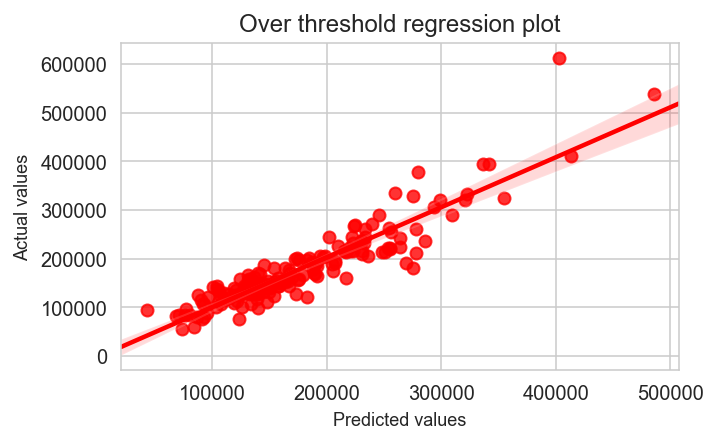

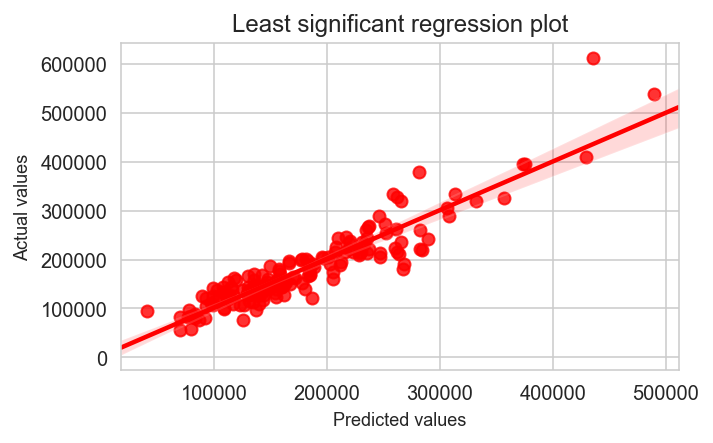

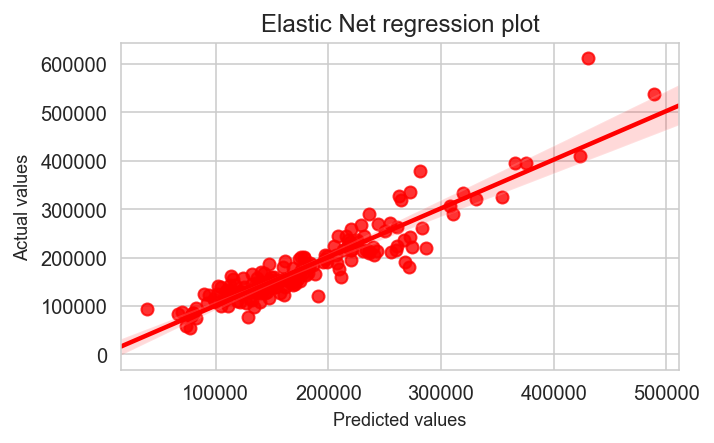

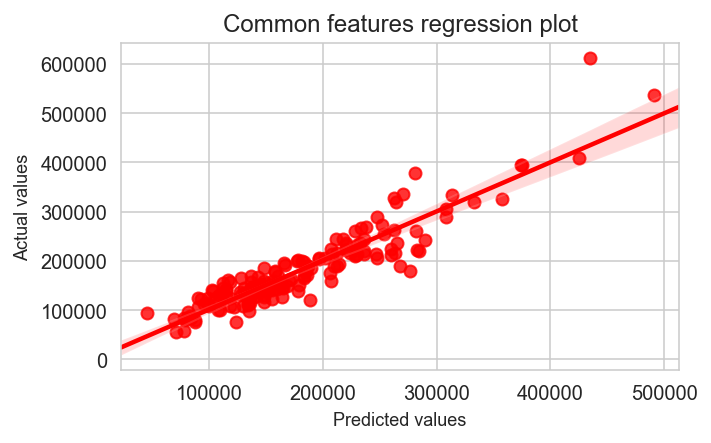

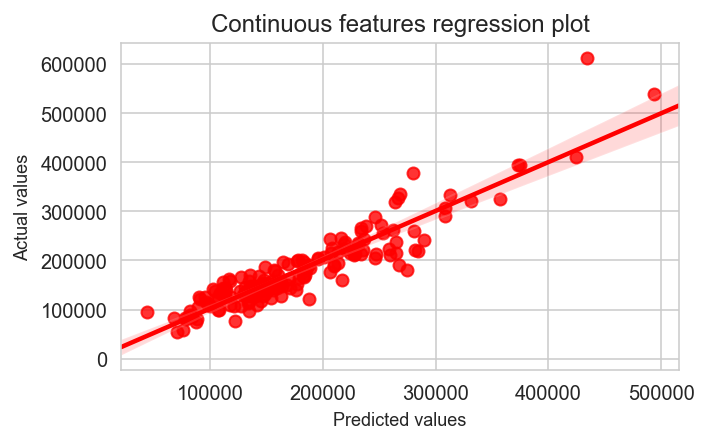

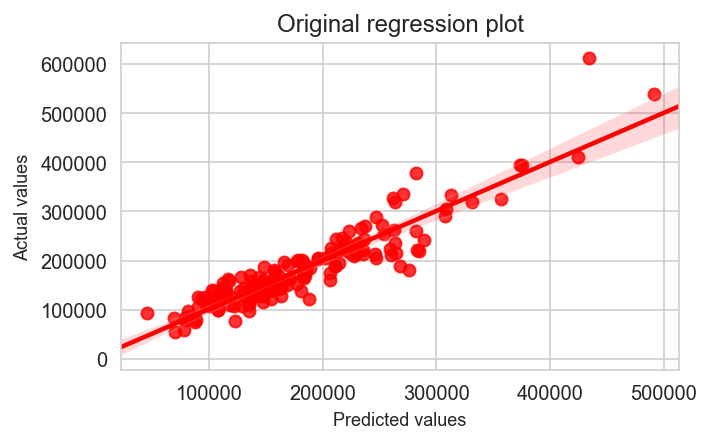

In [75]:
#Appending the original for comparison
predictions.append(('Original',y_pred))

#Plotting all the regressions for comparison
for pred in predictions:
    reg_plotter(pred[1],y_actual,labels=9,titlesize=12,title=pred[0])

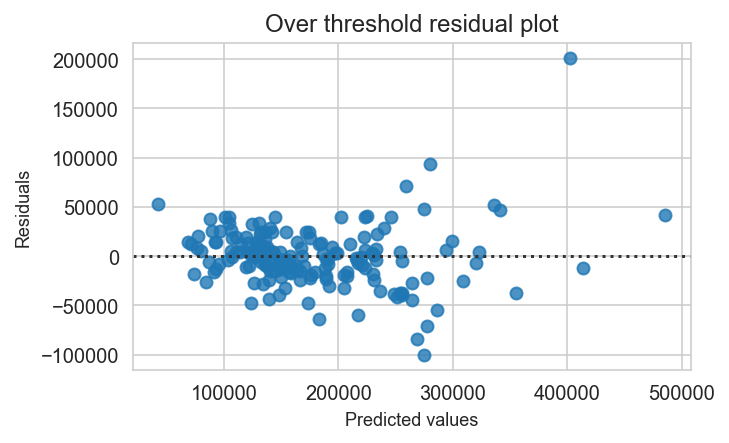

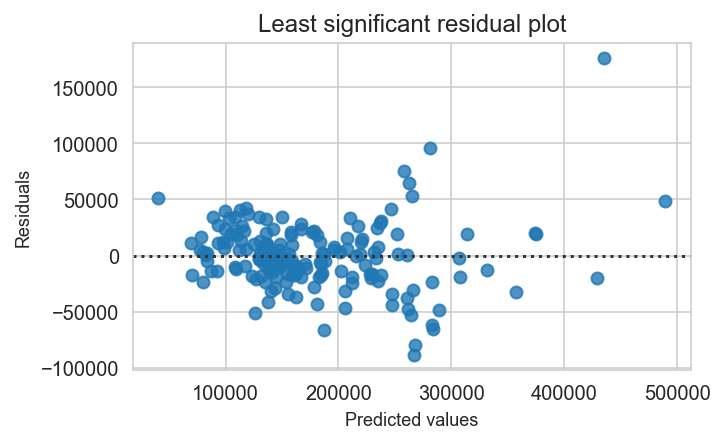

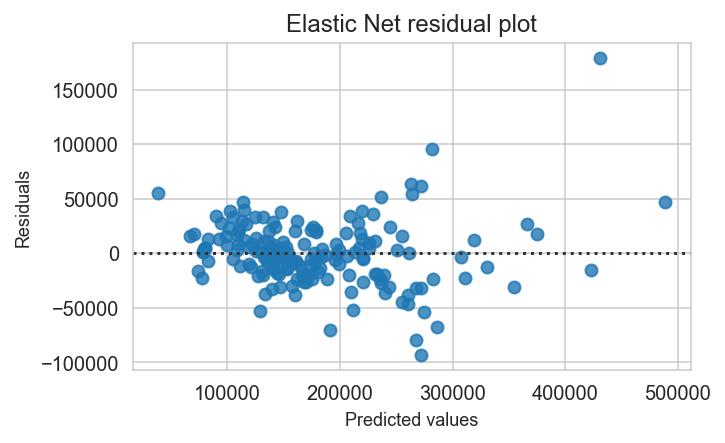

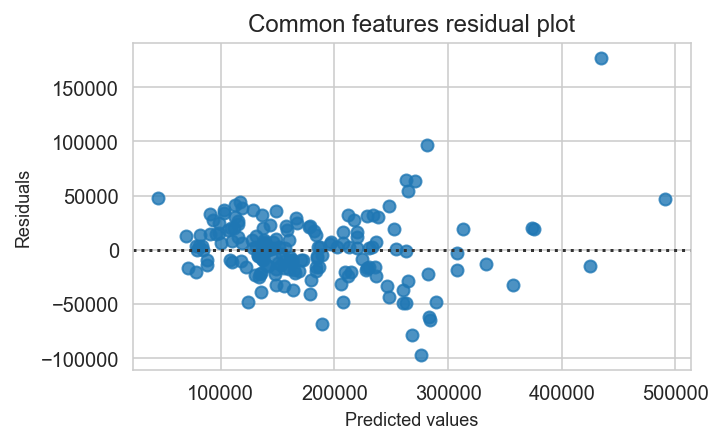

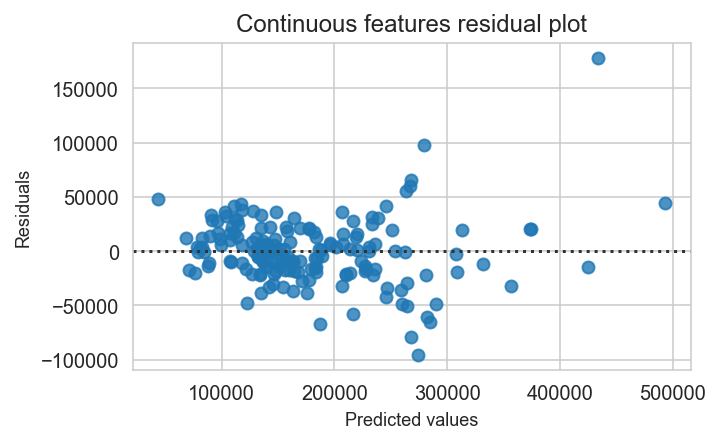

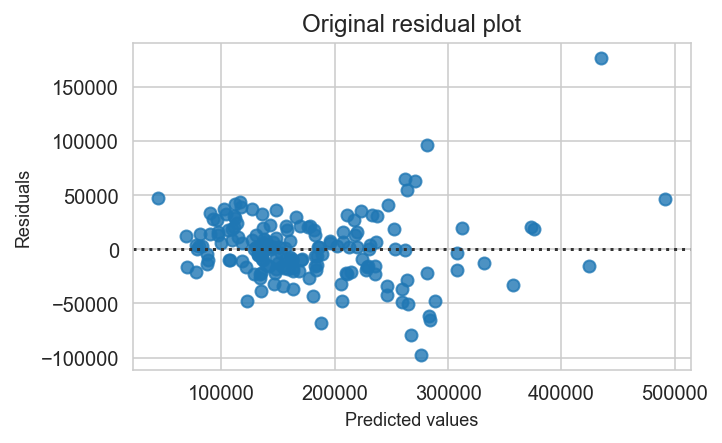

In [76]:
#Plotting all the residuals for comparison
for pred in predictions:
    resid_plotter(pred[1],y_actual,labels=9,titlesize=12,title=pred[0])

In [77]:
#With the Elastic Net model chosen, I will fit the non-standardised variables to get a better interpretation of coefs
model_orig_nonstd = sm.OLS(y_train,sm.add_constant(Xen_train)).fit()

orignonstd_html = model_orig_nonstd.summary().tables[1].as_html()
orightml_df = pd.read_html(orignonstd_html,header=0,index_col=0)[0]

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [78]:
#Sorting by largest to smallest, will talk about their interpretation below
orightml_df.sort_values(by='coef',ascending=False)

,coef,std err,t,P>|t|,[0.025,0.975]
Condition2_PosA,115700.0000,50100.000,2.312,0.021,17500.000,214000.000
Neighborhood_StoneBr,73520.0000,8501.388,8.648,0.000,56800.000,90200.000
Neighborhood_NridgHt,63510.0000,6044.351,10.508,0.000,51700.000,75400.000
Neighborhood_NoRidge,54640.0000,7377.828,7.406,0.000,40200.000,69100.000
SaleType_Con,46660.0000,37000.000,1.260,0.208,-26000.000,119000.000
Condition2_RRNn,37630.0000,41900.000,0.898,0.369,-44500.000,120000.000
Condition2_RRAn,37340.0000,47500.000,0.785,0.432,-55900.000,131000.000
Condition2_Artery,31630.0000,44300.000,0.713,0.476,-55400.000,119000.000
Condition2_Feedr,28430.0000,40200.000,0.707,0.480,-50500.000,107000.000
Neighborhood_NPkVill,27690.0000,13500.000,2.047,0.041,1151.170,54200.000


### Insights and conclusion:

* From everything I've done, it turns out the Elastic Net model worked the best! The improvement was very minimal between the two, so it just goes to show that good feature selection can rely purely on just looking at anything collinear and making logical decisions based on the data alone, rather than relying on mathematical methods to choose which ones to remove for me.

* With the coefficients:
    * Seems like the neighborhood where the house was located had the most consistent significant impact. With some neighborhoods severely impacting the price, and others being very insignificant. This suggests that houses in highly sought after areas will have a huge effect on price.
    
    * The proximity of the house to various 'conditions' also had a significant consistent impact on the price of the house. This is an extension of the neighborhood feature, but does impact that perhaps the reason the neighborhood is popular is because many houses are located to positive features like parks etc.
    
    * The sale type also has a significant impact. I think this highlights that perhaps the value of a property isn't so much about its inherent features, or the type of building material etc. It's about the location, and the 'sale condition', which can be interpreted as the market conditions.
    
    
* **Overall I think the model has strong predictive power and accurately identifies the strongest predictors of a house price. It is robust to the testing data, and I think the value associated with its coefficients can give a lot of insights into the nature of real estate**. 

(For part two I will be using the difference between the actual values: y_pred - y_actual *see below*)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [79]:
#Making a new dataframe with all columns that weren't fixed (i.e. variable)
var_df = haus_df[[col for col in haus_df.columns if col not in fixed_char]].copy()
#Dropping the 'Id' column as it is useless for our analysis
var_df.drop(columns=('Id'),inplace=True)

In [80]:
#Assigning the variable X which encapsulates the train and test data from before, this will only be used to define
#the new target
X = dummie_fixed_df[[col for col in dummie_fixed_df if col != 'SalePrice']]
#Scaling them as before
scale = StandardScaler()
Xstd = scale.fit_transform(X)
Xstd = sm.add_constant(Xstd)

#Making predictions on all train/test data based on the original (best) model
new_pred = model_orig.predict(Xstd)

#Making the actual values equal to SalePrice column in the original dataframe
y_real = dummie_fixed_df['SalePrice'].values

In [81]:
var_df['PriceVariance'] = y_real - new_pred

### Exploratory data analysis:

#### Removing nulls:

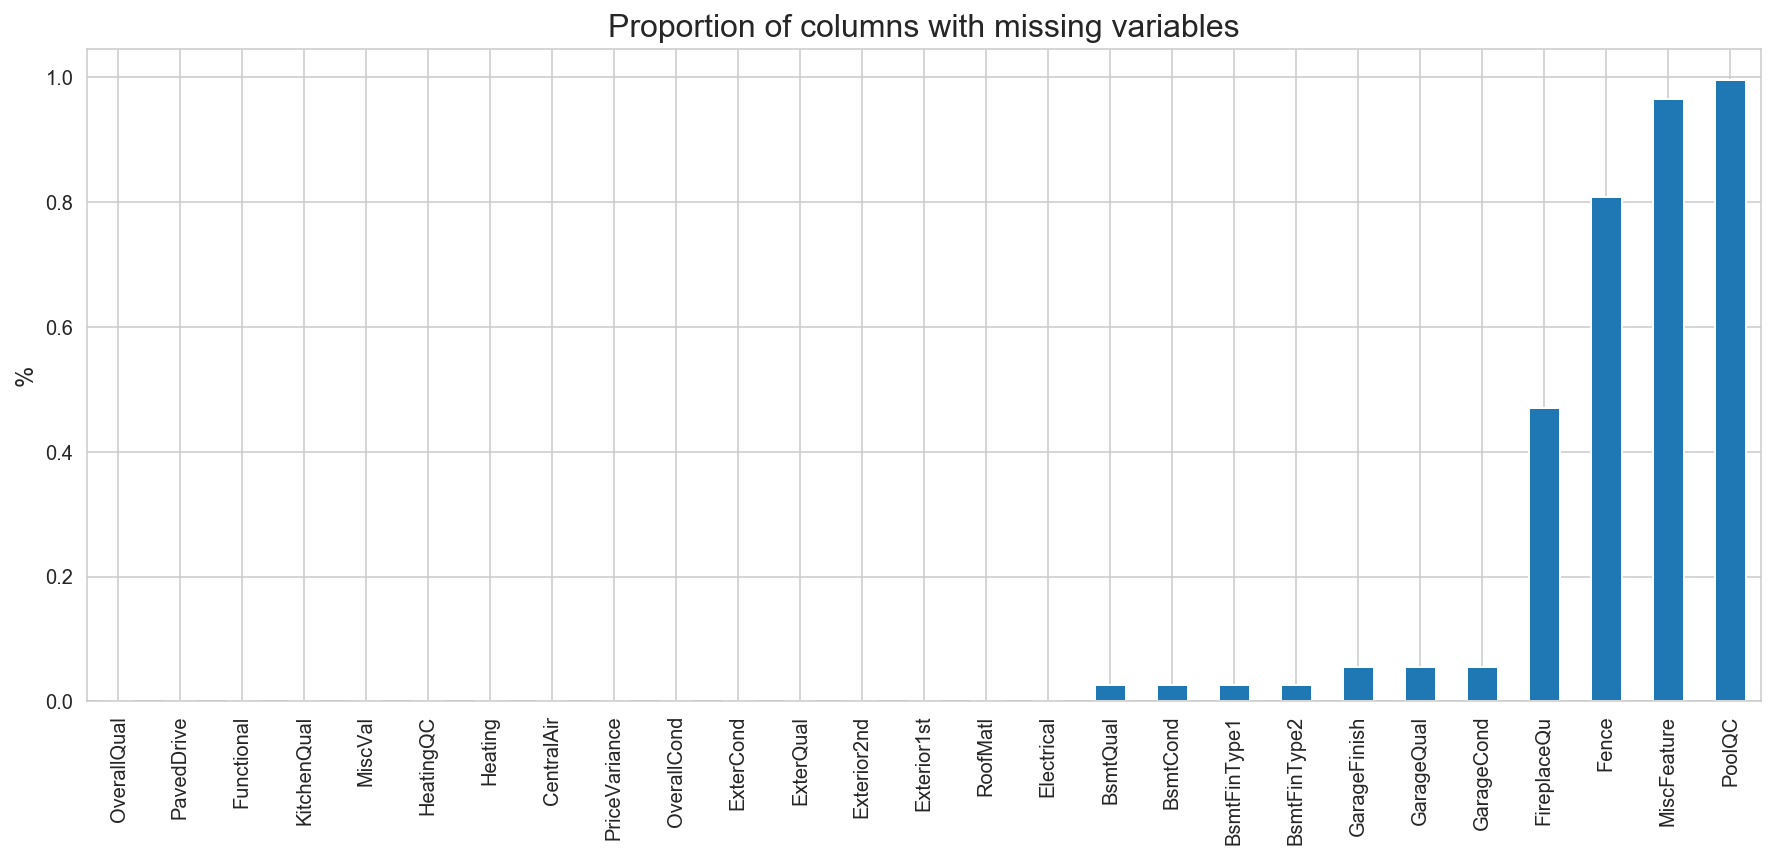

In [82]:
var_df.isnull().mean().sort_values().plot(kind='bar',figsize=(15,6))
plt.title('Proportion of columns with missing variables',fontsize=16)
plt.ylabel('%',fontsize=12)
plt.show()

* I've identified all the columns with missing values. The top 3 columns all have values over 80% that are missing, so I will automatically remove them. **FireplaceQu** also has missing values but the NaN's in this case indicate that the property has no fireplace, so I will convert it to a continuous variable later on. For this reason when we dummify this column the NaN's will automatically not be included. So I will keep this for now.


* The other columns have a relatively small amount of missing values, so we will fill them instead.

In [83]:
#Putting the identified columns in a list
missing_cols_remove = ['PoolQC','MiscFeature','Fence']

#Removing them from the dataframe
var_df.drop(columns=missing_cols_remove,inplace=True)

#### Removing low variance features:

In [84]:
#Calling our function from before that identifies highly homogenous columns
var_checker(var_df,0.9)

RoofMatl
{'CompShg': 1424, 'Tar&Grv': 11, 'WdShngl': 6, 'WdShake': 5, 'ClyTile': 1, 'Metal': 1, 'Membran': 1, 'Roll': 1}
-------------------
BsmtCond
{'TA': 1303, 'Gd': 65, 'Fa': 43, 'Po': 2}
-------------------
Heating
{'GasA': 1419, 'GasW': 17, 'Grav': 7, 'Wall': 4, 'OthW': 2, 'Floor': 1}
-------------------
CentralAir
{'Y': 1361, 'N': 89}
-------------------
Electrical
{'SBrkr': 1328, 'FuseA': 90, 'FuseF': 27, 'FuseP': 3, 'Mix': 1}
-------------------
Functional
{'Typ': 1350, 'Min2': 34, 'Min1': 31, 'Mod': 15, 'Maj1': 14, 'Maj2': 5, 'Sev': 1}
-------------------
GarageQual
{'TA': 1303, 'Fa': 48, 'Gd': 14, 'Ex': 3, 'Po': 3}
-------------------
GarageCond
{'TA': 1319, 'Fa': 34, 'Gd': 9, 'Po': 7, 'Ex': 2}
-------------------
PavedDrive
{'Y': 1335, 'N': 85, 'P': 30}
-------------------


* Removing the highly homogenous columns is not as obvious as above, so to add depth I will write two function. One to just give me the columns identified as being homogenous. And the second to give me the mean variance of their dummie values

In [85]:
#Very similar function as I wrote above, except it just gives me the list of columns
def lowvar_names(df,thresh):
    for col in df:
        #Checks if the values in the column are 'numeric', if it is numeric it is assumed to be a continuous variable
        #and therefore excluded, we only want categorical variables
        if all(df[col].apply(lambda x:str(x).isnumeric())) == False:
            if df[col].value_counts(normalize=True).max() > thresh:
                #Gives me only the columns
                yield col 

In [86]:
#This function returns the mean variance for each column's dummie variables
def new_var_checker(hcol,df):
    for col in hcol:
        hdf = pd.get_dummies(df[col])
        mean_ = np.mean([hdf[subcol].var() for subcol in hdf])
        #Returns the name and the mean variance of its dummies
        yield col, mean_

In [87]:
#This variable gives us the names of the low variance columns
low_var_cols = list(lowvar_names(var_df,0.9))

In [88]:
#Sorts the values by lowest first, we can see that it is similar to the first test, but slightly different
pd.DataFrame(list(new_var_checker(low_var_cols,var_df))).sort_values(by=1)

,0,1
0,RoofMatl,0.004435
2,Heating,0.007027
5,Functional,0.018864
7,GarageCond,0.023502
6,GarageQual,0.027379
4,Electrical,0.031282
1,BsmtCond,0.041047
8,PavedDrive,0.049523
3,CentralAir,0.057652


* Now that I've run the two tests, I can make a more informed decision. **RoofMatl** is the top of both lists, so I will remove that. **Heating** also has extremely low variance so it will also be removed. There are other low variance features, but I will keep those for now.

In [89]:
#Yes, it's a long variable name, I am not very creative
low_var_cols_to_remove = ['RoofMatl','Heating']

#Removing the defined columns above from the dataframe
var_df.drop(columns=low_var_cols_to_remove,inplace=True)

### Converting into continuous variables:

In [90]:
#All the ordinal features I have identified
ordinal_feats = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual',
                 'Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond']

#Splitting them into their rating systems: Ex,Gd,TA,Fa,Po,NA etc. for these columns
rating_feats_1 = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual',
                  'GarageCond']
#Finish rating: GLQ,ALQ,BLQ,Rec,LwQ,Unf,NA
rating_feats_2 = ['BsmtFinType1','BsmtFinType2']

#Functionality rating: Typ,Min1,Min2,Mod,Maj1,Maj2,Sev,Sal
misc1 = ['Functional']

#GFinish rating: Fin,RFn,Unf,NA
misc2 = ['GarageFinish']

In [91]:
#Checking if all the columns I've typed above are in the dataframe
print(all([feat in var_df.columns for feat in ordinal_feats]))
print(all([feat in var_df.columns for feat in rating_feats_1]))
print(all([feat in var_df.columns for feat in rating_feats_2]))
print(all([feat in var_df.columns for feat in misc1]))
print(all([feat in var_df.columns for feat in misc2]))

#Yarr they be true, so I can proceed matey

True
True
True
True
True


In [92]:
#Function that converts all the items in rating_feats_1 to numeric values
def rating1_numeric(x):
    if x == 'NA':
        return 0
    if x == 'Po':
        return 1
    if x == 'Fa':
        return 2
    if x == 'TA':
        return 3
    if x == 'Gd':
        return 4
    if x == 'Ex':
        return 5
    else:
        return 0

In [93]:
#Function that converts all the items in rating_feats_2 to numeric values
def rating2_numeric(x):
    if x == 'NA':
        return 0
    if x == 'Unf':
        return 1
    if x == 'LwQ':
        return 2
    if x == 'Rec':
        return 3
    if x == 'BLQ':
        return 4
    if x == 'ALQ':
        return 5
    if x == 'GLQ':
        return 6
    else:
        return 0

In [94]:
#Function that converts all the items in misc1 to numeric values
def misc1_numeric(x):
    if x == 'Sal':
        return 0
    if x == 'Sev':
        return 1
    if x == 'Maj2':
        return 2
    if x == 'Maj1':
        return 3
    if x == 'Mod':
        return 4
    if x == 'Min2':
        return 5
    if x == 'Min1':
        return 6
    if x == 'Typ':
        return 7
    else:
        return 0

In [95]:
#Function that converts all the items in misc2 to numeric values
def misc2_numeric(x):
    if x == 'NA':
        return 0
    if x == 'Unf':
        return 1
    if x == 'RFn':
        return 2
    if x == 'Fin':
        return 3
    else:
        return 0

In [96]:
#Now applying the four different functions to the four different categorical rating systems as defined above
for feats1 in rating_feats_1:
    var_df[feats1] = var_df[feats1].apply(rating1_numeric)
    
for feats2 in rating_feats_2:
    var_df[feats2] = var_df[feats2].apply(rating2_numeric)
    
for feats3 in misc1:
    var_df[feats3] = var_df[feats3].apply(misc1_numeric)
    
for feats3 in misc2:
    var_df[feats3] = var_df[feats3].apply(misc2_numeric)

In [97]:
#CentralAir should be converted to a 1 and 0 since it is a binary category
var_df['CentralAir'] = var_df['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

In [98]:
#Checking for any final missing values
var_df.isnull().sum().sort_values(ascending=False)

Electrical       1
PriceVariance    0
BsmtFinType2     0
OverallCond      0
Exterior1st      0
Exterior2nd      0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
BsmtFinType1     0
HeatingQC        0
MiscVal          0
CentralAir       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
OverallQual      0
dtype: int64

In [99]:
#Finding the row, it seems everything is normal with the house, except its missing electricity type
var_df[var_df['Electrical'].isnull() == True]

,OverallQual,OverallCond,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,MiscVal,PriceVariance
1369,5,5,VinylSd,VinylSd,3,3,4,3,1,1,4,1,NaN,4,7,0,3,3,3,Y,0,-27146.410308


In [100]:
#Will just replace it with the mode of the possible variables, as this is most likely just a mistake
var_df['Electrical'] = var_df['Electrical'].fillna('SBrkr')

In [101]:
#Checking one last time for any missing values
var_df.isnull().sum().sort_values(ascending=False)
#S'all good!

PriceVariance    0
MiscVal          0
OverallCond      0
Exterior1st      0
Exterior2nd      0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
BsmtFinType1     0
BsmtFinType2     0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
OverallQual      0
dtype: int64

### Dealing with multicollinearity:

In [102]:
#Calling the function that identifies highly correlated variables above our threshold
corr_finder(var_df,1.0,0.8)

,,Correlation
GarageQual,GarageCond,0.958944
GarageCond,GarageQual,0.958944


* Luckily this time our correlation finder function only found one set of variable that were highly correlated to one another that was **GarageQual** and **GarageCond**. Garage quality and condition seem interchangeable with each other. In my opinion, 'quality' is a little more subjective than 'condition'. So going ahead I will remove the **GarageQual** feature from the data.

In [103]:
#Dropping the garagequal feature as shown above
var_df.drop(columns=['GarageQual'],inplace=True)

In [104]:
#Running the finder function again to see if there are any highly correlated feature remaining
corr_finder(var_df,1,0.8)

,,Correlation


### Dummifying the data:

In [105]:
#Identifying the columns that need to be converted into dummy variables
dummie_cols_var = ['Exterior1st','Exterior2nd','Electrical','PavedDrive']

#Checking if the columns are all objects
var_df[dummie_cols_var].dtypes

Exterior1st    object
Exterior2nd    object
Electrical     object
PavedDrive     object
dtype: object

In [106]:
#Assigning a new temp dataframe that is the dummies of all the above mentioned categorical columns
temp_df_var = pd.get_dummies(var_df[dummie_cols_var])

#Concatenating it onto the original dataframe
dummie_var_df = pd.concat([temp_df_var,var_df],axis=1)

#Dropping the columns that were converted into dummies, so we only have numerical and dummies variables in our model
dummie_var_df.drop(columns=dummie_cols_var,inplace=True)

In [107]:
#Creating the 'YrSold_2010' column in the new dummie dataframe based on the fixed dataframe's 'YrSold_2010' column
dummie_var_df['YrSold_2010'] = dummie_fixed_df['YrSold_2010']

* Doing another quick check of the correlation of the variables and removing them based on whether they are redundant / telling the same information or not.

In [108]:
dummie_var_df.corr()[['Exterior2nd_ImStucc']]

,Exterior2nd_ImStucc
Exterior1st_AsbShng,-0.009602
Exterior1st_AsphShn,-0.002189
Exterior1st_BrkComm,-0.003097
Exterior1st_BrkFace,-0.015585
Exterior1st_CBlock,-0.002189
Exterior1st_CemntBd,-0.017464
Exterior1st_HdBoard,0.010853
Exterior1st_ImStucc,0.315244
Exterior1st_MetalSd,-0.034770
Exterior1st_Plywood,0.072105


In [109]:
dummie_var_cols_to_drop = ['Exterior2nd_VinylSd','Exterior2nd_CmentBd','Exterior2nd_MetalSd','Exterior2nd_HdBoard',
                           'Exterior2nd_Wd Sdng','Exterior1st_AsbShng']

In [110]:
dummie_var_df.drop(columns=dummie_var_cols_to_drop,inplace=True)

### Building the model (round 1):

In [111]:
#Making a dataframe with only the years before 2010
train_var_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 0].copy()

Xvar_train = train_var_df.drop(columns=['YrSold_2010','PriceVariance']).copy()
yvar_train = train_var_df['PriceVariance'].values

#Making a dataframe with everything at 2010
test_var_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 1].copy()

Xvar_test = test_var_df.drop(columns=['YrSold_2010','PriceVariance']).copy()
yvar_test = test_var_df['PriceVariance'].values

#Standardising the X training values for the model via the sklearn.preprocessing module
scale = StandardScaler()
Xvarstd_train = scale.fit_transform(Xvar_train)
Xvarstd_train = sm.add_constant(Xvarstd_train,has_constant='add')

#Standardising the X testing values for the model via the sklearn.preprocessing module
Xvarstd_test = scale.transform(Xvar_test)
Xvarstd_test = sm.add_constant(Xvarstd_test,has_constant='add')

In [112]:
model_var_orig = sm.OLS(yvar_train,Xvarstd_train).fit()

In [113]:
model_var_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     3.748
Date:                Thu, 31 Oct 2019   Prob (F-statistic):           6.33e-15
Time:                        12:55:16   Log-Likelihood:                -14907.
No. Observations:                1278   AIC:                         2.991e+04
Df Residuals:                    1232   BIC:                         3.014e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -509.3337    802.029     -0.635      0.526   -2082.827    1064.160
x1          1.057e-12   1.13e-12      0.938      0.349   -1.15e-12    3.27e-12
x2          -174.8844   1155.566     -0.151      0.880   -2441.980    2092.211
x3          1219.5176   2619.283      0.466      0.642   -3919.231    6358.267
x4          -102.4402    453.358     -0.226      0.821    -991.878     786.998
x5           680.0886   3019.688      0.225      0.822   -5244.211    6604.388
x6         -3702.7078   5219.406     -0.709      0.478   -1.39e+04    6537.201
x7         -1981.6450    940.612     -2.107      0.035   -3827.023    -136.267
x8         -1659.0902   5181.973     -0.320      0.749   -1.18e+04    8507.378
x9         -2038.7234   3734.371     -0.546      0.585   -9365.153    5287.707
x10         -679.1153   1028.813     -0.660      0.509   -2697.535    1339.305
x11        -2629.8504   2157.733     -1.219      0.223   -6863.087    1603.387
x12        -4827.0935   6977.917     -0.692      0.489   -1.85e+04    8862.821
x13        -2745.7012   5024.476     -0.546      0.585   -1.26e+04    7111.775
x14         -329.0831   2167.968     -0.152      0.879   -4582.400    3924.234
x15         -799.7368   1637.078     -0.489      0.625   -4011.505    2412.032
x16         -391.7038    807.548     -0.485      0.628   -1976.025    1192.617
x17          114.3965   1054.234      0.109      0.914   -1953.896    2182.689
x18          111.5105   1144.362      0.097      0.922   -2133.603    2356.624
x19         -102.4402    453.358     -0.226      0.821    -991.878     786.998
x20         1964.2914    879.235      2.234      0.026     239.328    3689.255
x21        -1354.6742    803.829     -1.685      0.092   -2931.699     222.351
x22         -564.5219   1360.460     -0.415      0.678   -3233.596    2104.552
x23         -641.9755    905.259     -0.709      0.478   -2417.994    1134.044
x24        -1018.9000   1402.457     -0.727      0.468   -3770.369    1732.569
x25        -1019.4125   1029.039     -0.991      0.322   -3038.275     999.450
x26          850.9758    556.627      1.529      0.127    -241.067    1943.018
x27          101.2965    795.312      0.127      0.899   -1459.019    1661.612
x28         -451.0124    859.625     -0.525      0.600   -2137.503    1235.478
x29         -149.3687    830.103     -0.180      0.857   -1777.940    1479.203
x30         -699.2744    479.032     -1.460      0.145   -1639.082     240.534
x31          631.8735    602.443      1.049      0.294    -550.054    1813.801
x32         -485.4528    725.581     -0.669      0.504   -1908.964     938.058
x33         -290.7978    480.634     -0.605      0.545   -1233.749     652.154
x34         6527.9514   1446.971      4.511      0.000    3689.152    9366.751
x35         5427.2213    959.049      5.659      0.000    3545.671    7308.772
x3

### Evaluation:

In [114]:
y_actual_var = yvar_test
y_pred_var = model_var_orig.predict(Xvarstd_test)

In [115]:
#Printing the R^2 of the model's predictions against the actual values
print('R^2:')
print(R2_manual(y_pred_var,y_actual_var))

R^2:
0.06657594190742822


In [116]:
#Now we're using our predicted values generated from our model and using mean squared error to evaluate 
print('RMSE:')
print('Baseline :',baseline(yvar_test))
print('Original :',np.sqrt(mean_squared_error(y_actual_var, y_pred_var)))

RMSE:
Baseline : 29902.51426946684
Original : 28889.97735334245


In [117]:
print('Mean Absolute Error:')
print('Baseline :', baseline_abs(y_actual_var))
print('Original :', mean_absolute_error(y_actual_var,y_pred_var))

Mean Absolute Error:
Baseline : 21274.692295618872
Original : 20692.43406720687


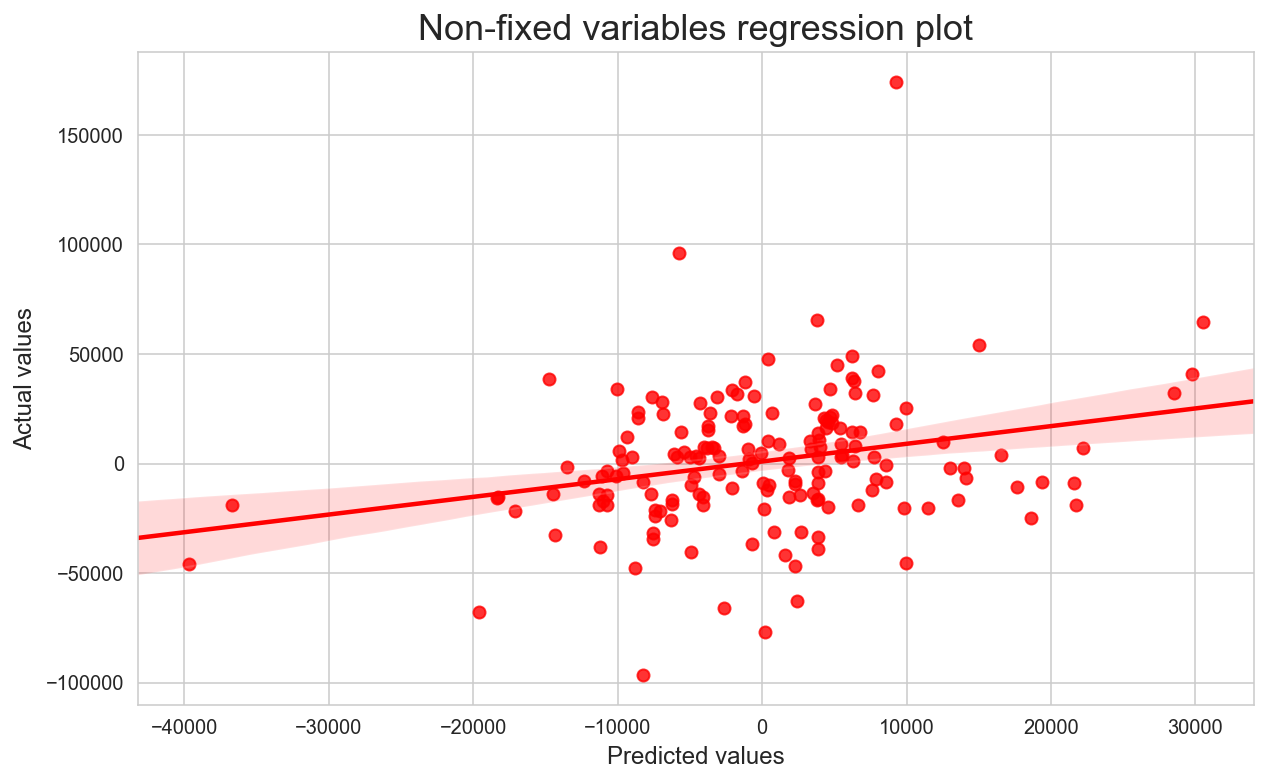

In [118]:
#Calling my function from before
reg_plotter(y_pred_var,y_actual_var,size=(10,6),title='Non-fixed variables')

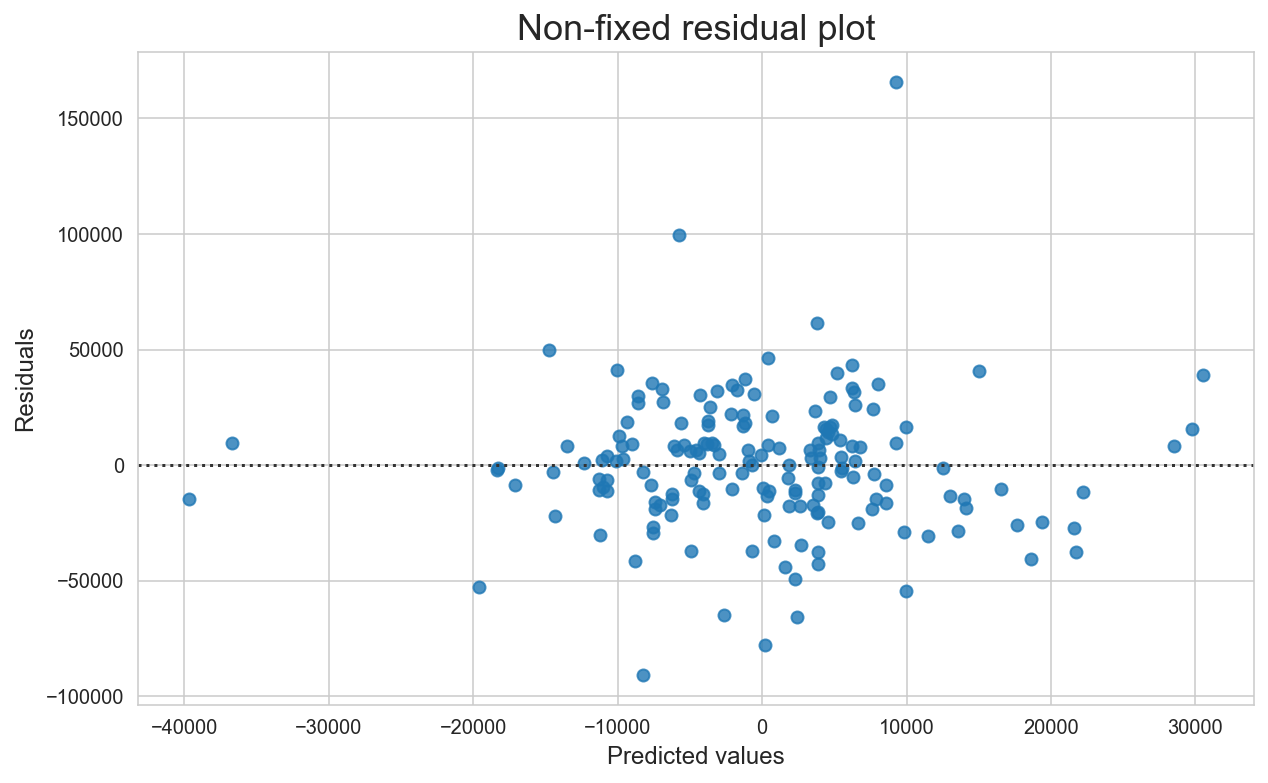

In [119]:
#Calling my function from before
resid_plotter(y_pred_var,y_actual_var,size=(10,6),title = 'Non-fixed')

### Building the model (round 2):

#### Least Significant:

In [120]:
#Calling the enhanced summary function like before to give me the coefficient names
enhanced_var_summary = summary_helper(yvar_train,Xvar_train)
enhanced_var_summary;

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [121]:
#Names of all the variables with p-value greater than 0.05
least_sig_var = list(enhanced_var_summary[enhanced_var_summary['P>|t|'] > 0.05].index)
#Removing the constant since we want to keep that in our model
least_sig_var.remove('const')

#### Elastic Net:

In [122]:
#Generates an array of ratios between 0.01 and 1 to find the optimal ratio it will iterate through 0.01,0.02..0.99 etc.
l1_ratios = np.linspace(0.01, 1.0, 100)

#Using the ElasticNetCV to find the optimal l1 ratio and alpha, cross validating over 10 folds, verbose=1 to reduce
#computational processing time
opt_en_var = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, verbose=1,n_jobs=-1)
opt_en_var.fit(Xvarstd_train,yvar_train)

#Printing out what the optimal alpha and ratio was
print('Optimal alpha is',opt_en_var.alpha_)
print('Optimal ratio is',opt_en_var.l1_ratio_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal alpha is 623.5936455584225
Optimal ratio is 1.0


...............................................................................................................................................[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.8s finished


In [123]:
#Using fit regularize with the optimal alpha and ratio
#Creating two models so I can use the 'norm' feature names for the 'stand' paramaters
mod_norm_var = sm.OLS(yvar_train,sm.add_constant(Xvar_train)).fit_regularized(method='elastic_net',
                                                                 alpha=opt_en_var.alpha_,L1_wt=opt_en_var.l1_ratio_)

#This is the model I'll actually be using
mod_stand_var = sm.OLS(yvar_train,Xvarstd_train).fit_regularized(method='elastic_net',
                                                       alpha=opt_en_var.alpha_,L1_wt=opt_en_var.l1_ratio_)

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [124]:
#Two new dataframes made from the above model parameters
mod_norm_var_df = pd.DataFrame(mod_norm_var.params)
mod_stand_var_df = pd.DataFrame(mod_stand_var.params)

#Naming the standard coefficients for reference for later
mod_stand_var_df.index = mod_norm_var_df.index

#Renaming for clarity
mod_stand_var_df.rename(columns={0:'coef_value'},inplace=True)
mod_stand_var_df.sort_values(by='coef_value')

,coef_value
Exterior1st_Stucco,-1538.803840
FireplaceQu,-931.850602
BsmtCond,-766.808050
Exterior1st_ImStucc,-740.357516
Exterior2nd_Other,-677.001567
Electrical_SBrkr,-622.774899
ExterCond,-230.043364
Exterior2nd_Stucco,-139.492551
GarageCond,-99.039982
BsmtQual,0.000000


In [125]:
#Assigning variable for the coefficient names that had been regularised to 0
en_var_names = list(mod_stand_var_df[mod_stand_var_df['coef_value'] == 0].index)
en_var_names.remove('const')

In [126]:
#Making a variable with all the names of the coefficients that both Elastic Net and least significant wanted to remove
common_bad_var_feats = set(least_sig_var) & set(en_names)

In [127]:
#Making a variable with all the names that are only continuous and identified to be removed by EN/Significance
cont_bad_var_feats = ['BsmtQual','ExterQual','GarageFinish','HeatingQC','MiscVal']

In [132]:
#Creating differen dataframes with the columns dropped based on the different feature selection methods
#One dataframe for the training (pre 2010)
sig_var_train_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 0].drop(columns=least_sig_var).drop(columns='YrSold_2010').copy()
en_var_train_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 0].drop(columns=en_var_names).drop(columns='YrSold_2010').copy()
all_var_train_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 0].drop(columns=common_bad_var_feats).drop(columns='YrSold_2010').copy()
cont_var_train_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 0].drop(columns=cont_bad_var_feats).drop(columns='YrSold_2010').copy()

#Post 2010 dataframe for each feature selection method
sig_var_test_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 1].drop(columns=least_sig_var).drop(columns='YrSold_2010').copy()
en_var_test_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 1].drop(columns=en_var_names).drop(columns='YrSold_2010').copy()
all_var_test_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 1].drop(columns=common_bad_var_feats).drop(columns='YrSold_2010').copy()
cont_var_test_df = dummie_var_df[dummie_var_df['YrSold_2010'] == 1].drop(columns=cont_bad_var_feats).drop(columns='YrSold_2010').copy()

#Assigning all the training X's for all the different possible feature selection methods
Xsigvar_train = sig_var_train_df[[col for col in sig_var_train_df if col != 'PriceVariance']]
Xenvar_train = en_var_train_df[[col for col in en_var_train_df if col != 'PriceVariance']]
Xallvar_train = all_var_train_df[[col for col in all_var_train_df if col != 'PriceVariance']]
Xcontvar_train = cont_var_train_df[[col for col in cont_var_train_df if col != 'PriceVariance']]
yvar_train = dummie_var_df[dummie_var_df['YrSold_2010'] == 0]['PriceVariance'].values

#Assigning the testing X's for all the different possible feature selection methods
Xsigvar_test = sig_var_test_df[[col for col in sig_var_test_df if col != 'PriceVariance']]
Xenvar_test = en_var_test_df[[col for col in en_var_test_df if col != 'PriceVariance']]
Xallvar_test = all_var_test_df[[col for col in all_var_test_df if col != 'PriceVariance']]
Xcontvar_test = cont_var_test_df[[col for col in cont_var_test_df if col != 'PriceVariance']]
yvar_test = dummie_var_df[dummie_var_df['YrSold_2010'] == 1]['PriceVariance'].values

#Standardising them for the model
Xsigvarstd_train = scale.fit_transform(Xsigvar_train)
Xsigvarstd_train = sm.add_constant(Xsigvarstd_train, has_constant='add')

Xsigvarstd_test = scale.transform(Xsigvar_test)
Xsigvarstd_test = sm.add_constant(Xsigvarstd_test, has_constant='add')

Xenvarstd_train = scale.fit_transform(Xenvar_train)
Xenvarstd_train = sm.add_constant(Xenvarstd_train, has_constant='add')

Xenvarstd_test = scale.transform(Xenvar_test)
Xenvarstd_test = sm.add_constant(Xenvarstd_test, has_constant='add')

Xallvarstd_train = scale.fit_transform(Xallvar_train)
Xallvarstd_train = sm.add_constant(Xallvarstd_train, has_constant='add')

Xallvarstd_test = scale.transform(Xallvar_test)
Xallvarstd_test = sm.add_constant(Xallvarstd_test, has_constant='add')

Xcontvarstd_train = scale.fit_transform(Xcontvar_train)
Xcontvarstd_train = sm.add_constant(Xcontvarstd_train, has_constant='add')

Xcontvarstd_test = scale.transform(Xcontvar_test)
Xcontvarstd_test = sm.add_constant(Xcontvarstd_test, has_constant='add')

#Standardising them for the model

In [133]:
#Fitting the model to the standardised X variables
model_sig_var = sm.OLS(yvar_train,Xsigvarstd_train).fit()
model_en_var = sm.OLS(yvar_train,Xenvarstd_train).fit()
model_all_var = sm.OLS(yvar_train,Xallvarstd_train).fit()
model_cont_var = sm.OLS(yvar_train,Xcontvarstd_train).fit()

#Making a list of the models for iterating
models_var = [model_sig_var,model_en_var,model_all_var,model_cont_var]

In [134]:
#Assigning the model's predicted values to a variable name
ysigvar_pred = ['Over threshold',model_sig_var.predict(Xsigvarstd_test)]
yenvar_pred = ['Elastic Net',model_en_var.predict(Xenvarstd_test)]
yallvar_pred = ['Common features',model_all_var.predict(Xallvarstd_test)]
ycontvar_pred = ['Continuous features',model_cont_var.predict(Xcontvarstd_test)]

#Making a list of the predictions for iterataing
predictions_var = [ysigvar_pred,yenvar_pred,yallvar_pred,ycontvar_pred]

In [135]:
#Now we're using our predicted values generated from our model and using mean squared error to evaluate 
y_actual_var = yvar_test

#Printing the RMSE for all the different models to compare
print('RMSE:')
print('----------')
for pred in predictions_var:
    print(pred[0],':',np.sqrt(mean_squared_error(y_actual_var, pred[1])))
    
#Printing the baseline and original for further comparison
print('----------')
print('Baseline :',baseline(yvar_test))
print('Original :',np.sqrt(mean_squared_error(y_actual_var, y_pred_var)))

RMSE:
----------
Over threshold : 28694.936190469503
Elastic Net : 28903.221343315025
Common features : 28889.97735334245
Continuous features : 28792.830865090506
----------
Baseline : 29902.51426946684
Original : 28889.97735334245


In [136]:
#The same as above, just with the absolute squared error
print('Mean ABS Err:')
print('----------')
for pred in predictions_var:
    print(pred[0],':',mean_absolute_error(y_actual_var,pred[1]))

print('----------')
print('Baseline :',baseline_abs(y_actual_var))
print('Original :',mean_absolute_error(y_actual_var, y_pred_var))

Mean ABS Err:
----------
Over threshold : 20282.484243551633
Elastic Net : 20569.973372703338
Common features : 20692.43406720687
Continuous features : 20584.588962593694
----------
Baseline : 21274.692295618872
Original : 20692.43406720687


In [137]:
#The same, but for R^2 
print('R^2:')
print('----------')
for pred in predictions_var:
    print(pred[0],':',R2_manual(pred[1],y_actual_var))

print('----------')
print('Original:',R2_manual(y_pred_var,y_actual_var))

R^2:
----------
Over threshold : 0.07913680795398292
Elastic Net : 0.06571992929652082
Common features : 0.06657594190742822
Continuous features : 0.0728429187316012
----------
Original: 0.06657594190742822


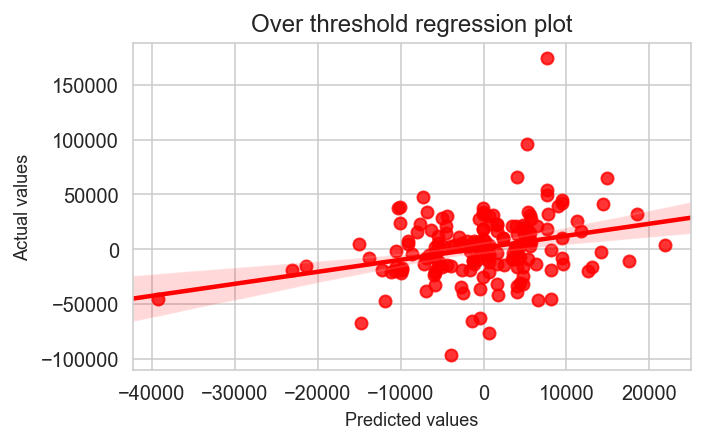

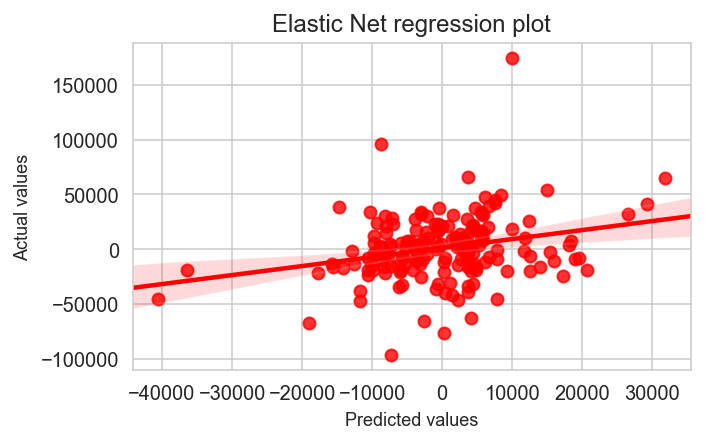

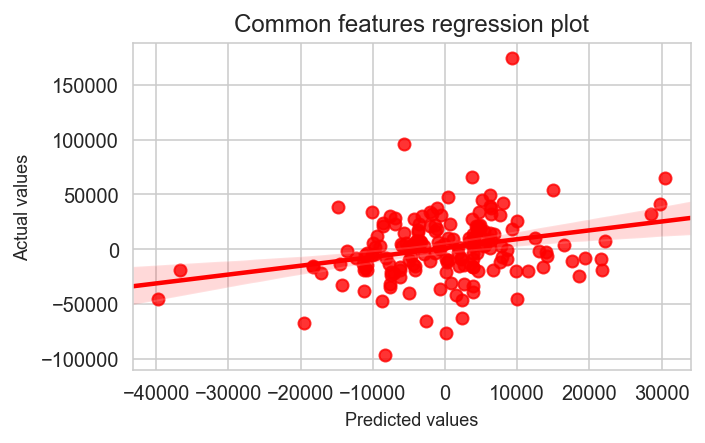

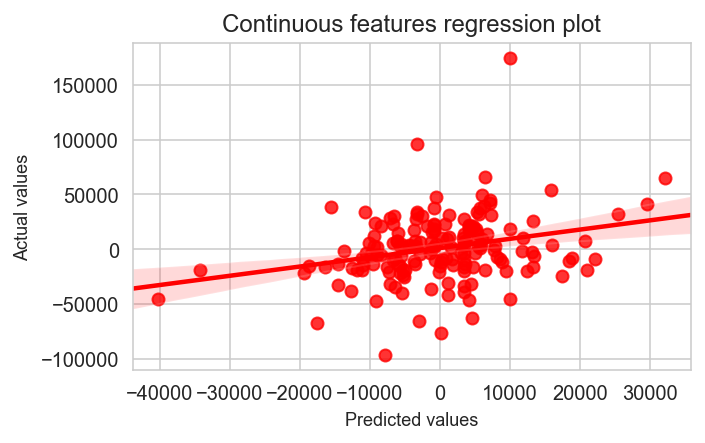

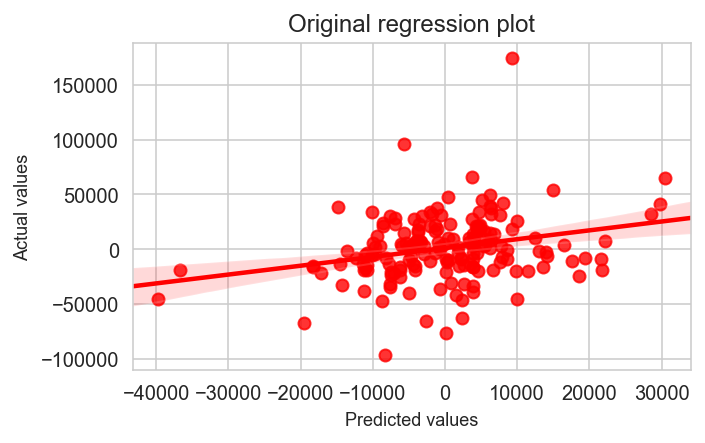

In [138]:
#Appending the original for comparison
predictions_var.append(('Original',y_pred_var))

#Plotting all the regressions for comparison
for pred in predictions_var:
    reg_plotter(pred[1],y_actual_var,labels=9,titlesize=12,title=pred[0])

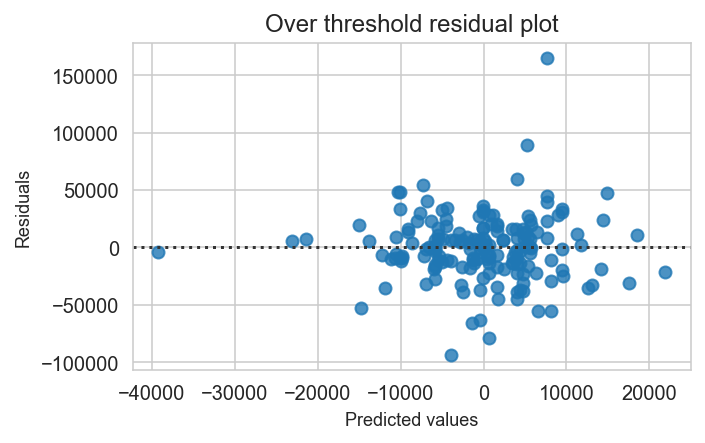

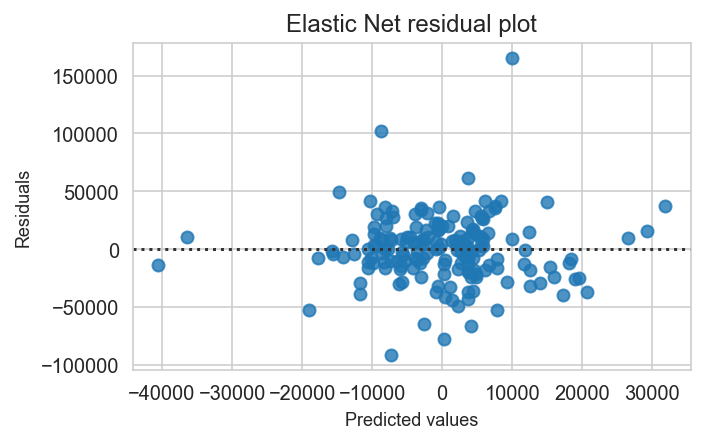

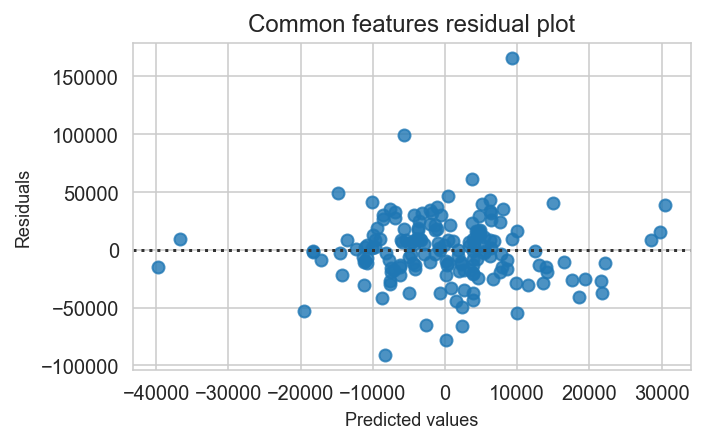

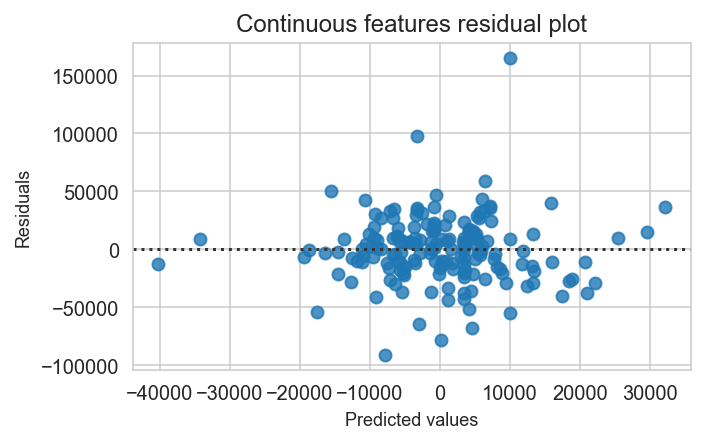

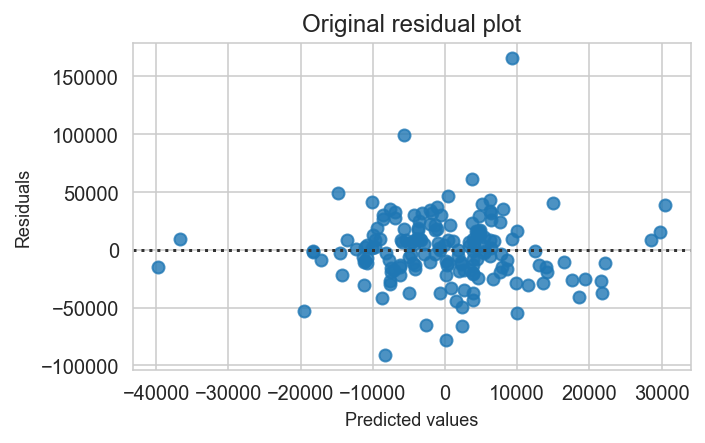

In [139]:
#Plotting all the residuals for comparison
for pred in predictions_var:
    resid_plotter(pred[1],y_actual_var,labels=9,titlesize=12,title=pred[0])

#### Insights and conclusion:
* The model I have created, isn't exactly an ideal predictor of the price variance from the first model. With a very low R^2, high RMSE and absolute mean error, it does not have much predictive power or reliability. Nevertheless, it does offer some predictive power, indicating that some of the rennovatable coefficients can predict some of the price variance. 

* From the testing, I will choose the Over Threshold model, which has removed all the features with a p-value over 0.05 (non-significant). Across all the testing methods (R^2, Mean Absolute Error and Root Mean Squared) it has performed the best. 

### Finding the coefficients for the best performing model:

* Now that I know the model to choose, I simply will build a the same model, but without the standardised features. To identify which features will have the biggest impact on the price variance.

* First I'll do a quick evaluation of the non-standardised coefficients:

In [140]:
#Fitting the new model
nonsigmod_nonstd = sm.OLS(yvar_train,sm.add_constant(Xsigvar_train)).fit()

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [141]:
sig_pred = nonsigmod_nonstd.predict(sm.add_constant(Xsigvar_test))

In [142]:
print("R^2:")
R2_manual(sig_pred,y_actual_var)

R^2:


0.07913680795398292

In [143]:
print("Mean Absolute Error:")
print("Non-std Model: ",mean_absolute_error(y_actual_var,sig_pred))
print("Baseline Model: ",baseline_abs(y_actual_var))

Mean Absolute Error:
Non-std Model:  20282.484243551644
Baseline Model:  21274.692295618872


In [144]:
print("RMSE:")
print("Non-std Model: ",np.sqrt(mean_squared_error(y_actual_var, sig_pred)))
print("Baseline Model: ",baseline(y_actual_var))

RMSE:
Non-std Model:  28694.936190469507
Baseline Model:  29902.51426946684


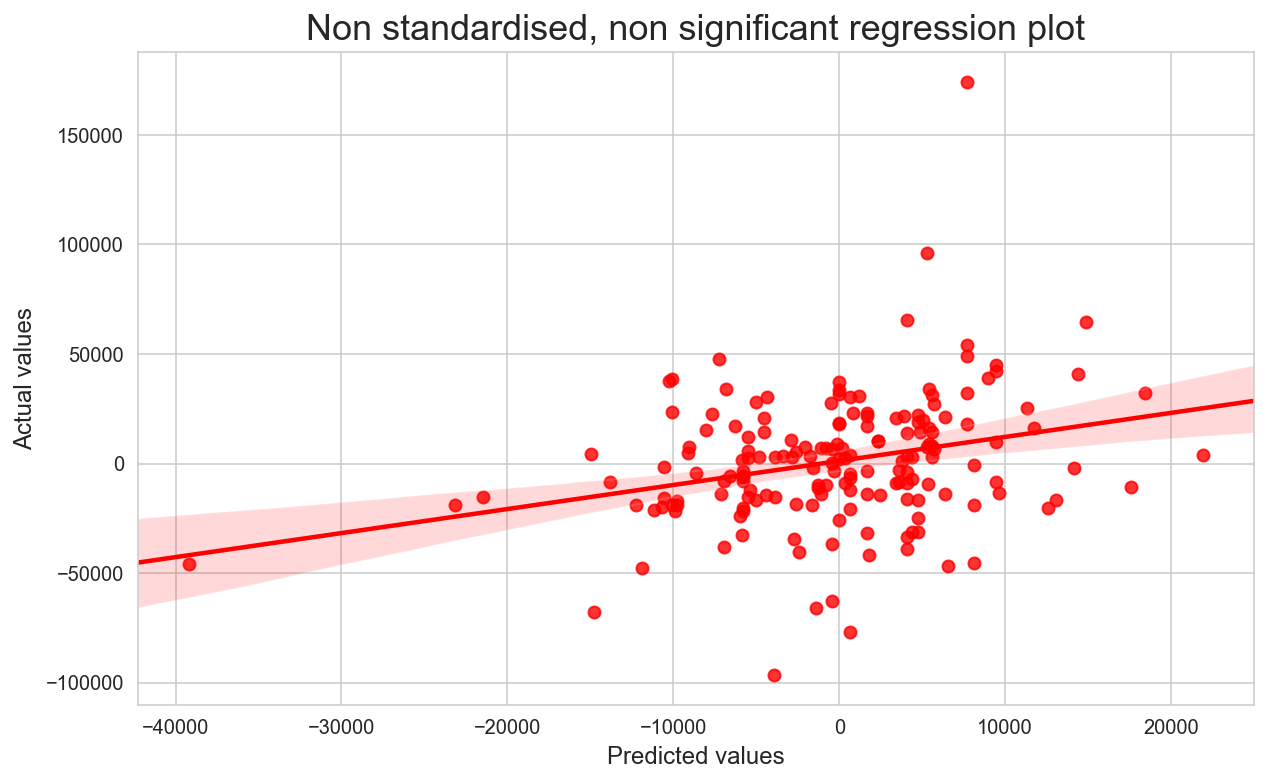

In [145]:
reg_plotter(sig_pred,y_actual_var,size=(10,6),title="Non standardised, non significant")

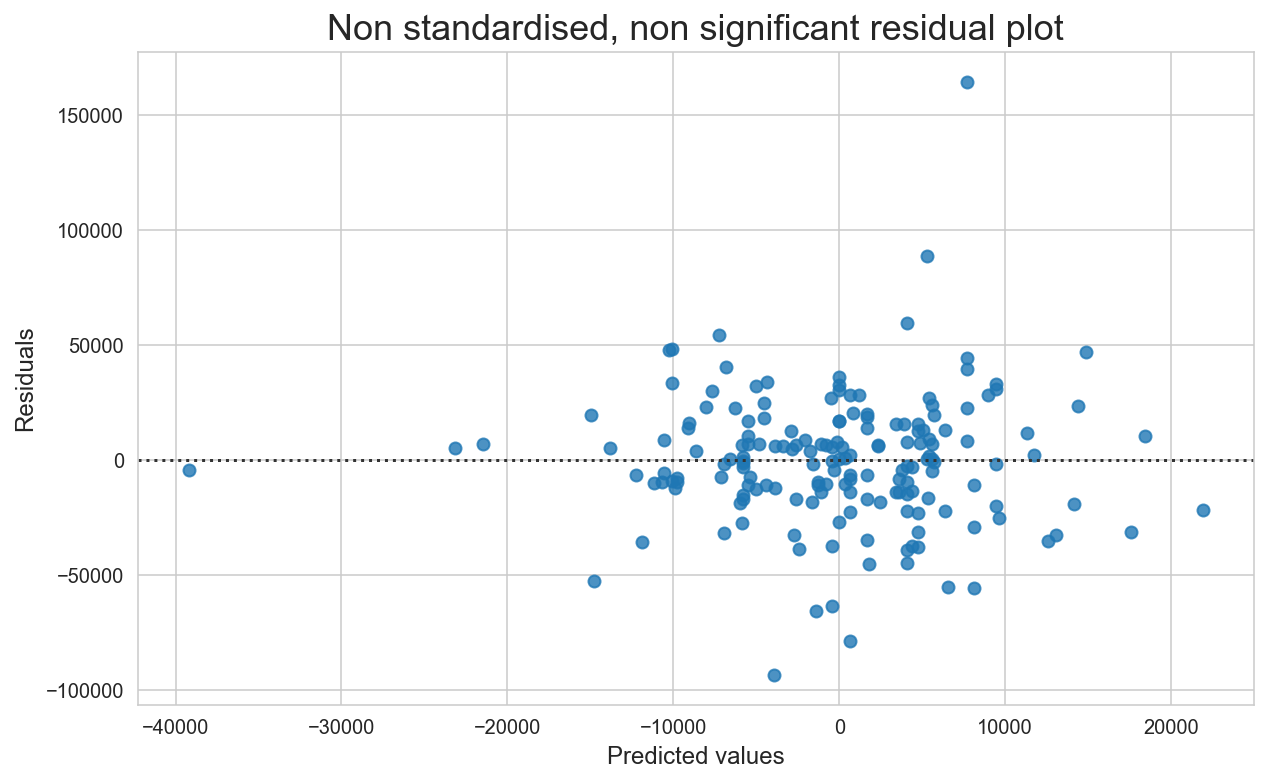

In [146]:
resid_plotter(sig_pred,y_actual_var,size=(10,6),title="Non standardised, non significant")

#### Interpeting the coefficients:

In [147]:
# Putting the summary into a table that can be sorted
html_sig = nonsigmod_nonstd.summary().tables[1].as_html()
sig_df = pd.read_html(html_sig,header=0,index_col=0)[0]

In [148]:
#Sorting the above dataframe by coefficients
sig_df.sort_values(by='coef',ascending=False)

,coef,std err,t,P>|t|,[0.025,0.975]
Exterior2nd_ImStucc,24350.0000,10300.000,2.364,0.018,4139.205,44600.000
OverallCond,4728.6434,748.771,6.315,0.000,3259.680,6197.607
OverallQual,4071.8629,698.892,5.826,0.000,2700.753,5442.973
Functional,3466.2887,1237.732,2.801,0.005,1038.064,5894.513
BsmtFinType1,481.9610,395.840,1.218,0.224,-294.612,1258.534
FireplaceQu,-1132.1765,515.444,-2.197,0.028,-2143.393,-120.960
Exterior1st_ImStucc,-61220.0000,30700.000,-1.992,0.047,-122000.000,-932.137
const,-75240.0000,9270.818,-8.116,0.000,-93400.000,-57100.000


* Now that we have our final product, we can interpret what each of the coefficient values mean:
    * From this model, we can see that having 'Imitation Stucco' as your secondary roof feature seems to have the biggest impact on price (surprisingly??). With having it increasing the value of house by 24350. 
    * Not surprisingly, the higher the overall quality and condition, the better the increase in price impact. 
    * Functionality and Fireplace Quality are also surprising on the list with a negative relationship. This could just be due to the relatively low predicting power of the model!
    
### Overall conclusion and responses:

* The company can use the first model, identify which fixed features can make the biggest increase in price. It can also perhaps infer from the residuals, which houses sold were overvalued or undervalued. There were a few outliers in this model, so they could definitely indicate those houses being sold far above their 'intrinsic' value, which theoretically the model would predict. 
    * **Thus, the business can use the residuals from the model to identify potential overvalued/undervalued properties and what their characteristics were to make them over/undervalued.**
    
* For the second model, since the target was the residuals themselves, although the model had very low predictive power, I believe the point of it was to demonstrate of the residuals, how much would be explained by the changeable feature (i.e. what can be rennovated) and what can be explained by the market conditions or the nature of the sale.
    * **For business the second model would highlight the relative low impact of rennovatable features, while highlighting the impact of general market conditions and the type of sale.**
    
* In general, I trust my first model over my second, in terms of predictability. The second model's worth is in highlighting the lack of impact that rennovatable features might have on the realtive under/over valuation of each property's sale price relative to the first model. 
    * Overall only about 8% of the price variance can be explained by the rennovatable features.
    * I believe that market conditions and the type of sale would offer greater explanation of the price variance

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [141]:
from sklearn.linear_model import LogisticRegression

In [142]:
# A:
haus_clean_df = pd.concat([dummie_fixed_df,dummie_var_df],axis=1)
haus_clean_df;

In [143]:
cols_to_drop = ['PriceVariance','YrSold_2010']
haus_clean_df.drop(columns=['PriceVariance','YrSold_2010'],inplace=True)

haus_clean_df['YrSold_2010'] = dummie_fixed_df['YrSold_2010']

In [144]:
salecond_2delete = [col for col in haus_clean_df.columns if 'SaleCondition' in col and not 'Abnorml' in col]

haus_clean_df.rename(columns={'SaleCondition_Abnorml':'Is_Abnormal'},inplace=True)

haus_clean_df.drop(columns=salecond_2delete,inplace=True)

In [145]:
haus_clean_df.isnull().sum().sort_values(ascending=False)

YrSold_2010              0
BldgType_2fmCon          0
HouseStyle_SFoyer        0
HouseStyle_2Story        0
HouseStyle_2.5Unf        0
HouseStyle_2.5Fin        0
HouseStyle_1Story        0
HouseStyle_1.5Unf        0
HouseStyle_1.5Fin        0
BldgType_TwnhsE          0
BldgType_Twnhs           0
BldgType_Duplex          0
BldgType_1Fam            0
RoofStyle_Flat           0
Condition2_RRNn          0
Condition2_RRAn          0
Condition2_RRAe          0
Condition2_PosN          0
Condition2_PosA          0
Condition2_Norm          0
Condition2_Feedr         0
Condition2_Artery        0
Condition1_RRNn          0
Condition1_RRNe          0
HouseStyle_SLvl          0
RoofStyle_Gambrel        0
MiscVal                  0
Foundation_Wood          0
MoSold_12                0
MoSold_11                0
MoSold_10                0
MoSold_1                 0
GarageType_Detchd        0
GarageType_CarPort       0
GarageType_BuiltIn       0
GarageType_Basment       0
GarageType_Attchd        0
G

In [215]:
names2 = list(orightml_df.sort_values(by='coef',ascending=False).index[:7])
names2

['Condition2_PosA',
 'Neighborhood_StoneBr',
 'Neighborhood_NridgHt',
 'SaleType_Con',
 'Neighborhood_NoRidge',
 'Condition2_RRAn',
 'Neighborhood_NPkVill']

In [232]:
X_cat = haus_clean_df[['SalePrice']].copy()
X_cat['Intercept'] = 1
y_cat = haus_clean_df['Is_Abnormal']

In [224]:
lr = LogisticRegression()
model_cat = lr.fit(X_cat,y_cat)

/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [225]:
model_cat.score(X_cat,y_cat)

0.9337931034482758

In [226]:
model_cat.intercept_

array([-2.58048292])

In [227]:
y_cat_pred=lr.predict(X_cat)

In [150]:
haus_clean_df['Is_Abnormal'].value_counts(normalize=True)

0    0.933793
1    0.066207
Name: Is_Abnormal, dtype: float64

In [151]:
for col in haus_clean_df.columns:
    haus_clean_df[col] = haus_clean_df[col].apply(float)

In [233]:
model_yay = sm3.Logit(y_cat,X_cat)

In [234]:
model_yay = model_yay.fit()

Optimization terminated successfully.
         Current function value: 0.236677
         Iterations 8


In [235]:
model_yay.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Is_Abnormal   No. Observations:                 1450
Model:                          Logit   Df Residuals:                     1448
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Oct 2019   Pseudo R-squ.:                 0.02888
Time:                        09:11:10   Log-Likelihood:                -343.18
converged:                       True   LL-Null:                       -353.39
Covariance Type:            nonrobust   LLR p-value:                 6.250e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SalePrice  -7.899e-06   1.97e-06     -4.018      0.000   -1.18e-05   -4.05e-06
Intercept     -1.3423      0.318     -4.227      0.000      -1.965      -0.720
==============================================================================
"""

In [ ]:
#I have no idea what the hell a 'Singular Matrix' error is, so I'm giving up here. Thank you and goodbye.